In [1]:
import os
from datetime import datetime

import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from scipy.stats import norm

# 1. Carregamento e tratamento inicial dos dados

In [2]:
def treat_timestamp(raw_date: int) -> datetime:
    str_date = str(raw_date)
    year = str_date[0:4]
    month = str_date[4:6]
    day = str_date[6:8]
    hour = str_date[8:10]
    minute = str_date[10:12]

    date_str = f"{year}-{month}-{day} {hour}:{minute}"

    return datetime.strptime(date_str, "%Y-%m-%d %H:%M")


def treat_data(path="data/b3_candles_raw.csv") -> pd.DataFrame:
    raw_data = pd.read_csv(path, sep=";")
    data = pd.DataFrame()

    data = raw_data.loc[:, ~raw_data.columns.str.startswith("UNK")].copy()

    # treat timestamp
    data["TIMESTAMP"] = (
        pd.to_datetime(data["TIMESTAMP"], format="%Y%m%d%H%M")
        # .dt.strftime("%Y-%m-%d %H:%M")
        .copy()
    )

    return data

In [3]:
data = treat_data("data/b3_candles_raw.csv")
data.info()

C:\Users\lucas\AppData\Local\Temp\ipykernel_28372\181786915.py:15: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv(path, sep=";")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7167175 entries, 0 to 7167174
Data columns (total 11 columns):
 #   Column     Dtype         
---  ------     -----         
 0   H          object        
 1   NAME       object        
 2   ID         int64         
 3   CLOSE      float64       
 4   OPEN       float64       
 5   HIGH       float64       
 6   LOW        float64       
 7   ADJ_CLOSE  float64       
 8   VOLUME     int64         
 9   TIMESTAMP  datetime64[ns]
 10  DAY_CLOSE  int64         
dtypes: datetime64[ns](1), float64(5), int64(3), object(2)
memory usage: 601.5+ MB


In [4]:
data.head()

,H,NAME,ID,CLOSE,OPEN,HIGH,LOW,ADJ_CLOSE,VOLUME,TIMESTAMP,DAY_CLOSE
0,H,ASAI3,3,14.12,13.88,14.18,13.88,0.00,1043100,2021-03-01 11:00:00,0
1,H,ASAI3,3,13.88,14.12,14.35,13.88,14.12,899700,2021-03-01 11:15:00,0
2,H,ASAI3,3,14.06,14.08,14.12,13.88,13.88,1007800,2021-03-01 11:30:00,0
3,H,ASAI3,3,14.10,14.06,14.16,14.04,14.06,346200,2021-03-01 11:45:00,0
4,H,ASAI3,3,13.98,14.09,14.11,13.89,14.10,425100,2021-03-01 12:00:00,0


In [5]:
len(data["NAME"].unique())

88

In [6]:
data["YEAR"] = data["TIMESTAMP"].dt.year

# 2. Análise de qualidade e consistência dos dados

 ## 2.1. Verificação de Dados Faltantes (Nulos)

In [7]:
valores_nulos = data.isnull().sum()
print("Contagem de valores nulos por coluna:")
display(valores_nulos)

Contagem de valores nulos por coluna:


H            0
NAME         0
ID           0
CLOSE        0
OPEN         0
HIGH         0
LOW          0
ADJ_CLOSE    0
VOLUME       0
TIMESTAMP    0
DAY_CLOSE    0
YEAR         0
dtype: int64

## 2.2. Consistência dos Candles (OHLC)

In [8]:
inc = data[
    (data["LOW"] > data["OPEN"])
    | (data["LOW"] > data["CLOSE"])
    | (data["HIGH"] < data["OPEN"])
    | (data["HIGH"] < data["CLOSE"])
].copy()


def get_inc_type(row):
    if row["LOW"] > row["OPEN"]:
        return "LOW>OPEN"
    elif row["LOW"] > row["CLOSE"]:
        return "LOW>CLOSE"
    elif row["HIGH"] < row["OPEN"]:
        return "HIGH<OPEN"
    else:
        return "HIGH<CLOSE"


inc["INC_TYPE"] = inc.apply(get_inc_type, axis=1)

inc_count = len(inc)
print(f"Qtd. de candles com valores OHLC inconsistentes: {inc_count}")

if inc_count > 0:
    print("Exemplos de registros inconsistentes:")
    display(inc.head())

Qtd. de candles com valores OHLC inconsistentes: 4
Exemplos de registros inconsistentes:


,H,NAME,ID,CLOSE,OPEN,HIGH,LOW,ADJ_CLOSE,VOLUME,TIMESTAMP,DAY_CLOSE,YEAR,INC_TYPE
600587,H,BBDC3,9,10.97,10.86,11.01,10.96,10.91,113700,2019-08-26 10:00:00,0,2019,LOW>OPEN
1819954,H,CSAN3,24,11.08,11.16,11.16,11.11,11.16,22400,2019-07-31 15:45:00,0,2019,LOW>CLOSE
2951207,H,GGBR4,38,7.44,7.49,7.50,7.46,7.49,343200,2019-07-31 15:45:00,0,2019,LOW>CLOSE
4694378,H,PETR3,57,8.96,9.03,9.03,8.99,9.03,187500,2019-07-31 15:45:00,0,2019,LOW>CLOSE


## 2.3. Análise de Volume Zero

In [9]:
zero_vol = data[data["VOLUME"] == 0]
zero_vol_count = len(zero_vol)
zero_vol_pctg = (zero_vol_count / len(data)) * 100

print(f"Número de candles com volume de negociação igual a zero: {zero_vol_count}")
print(f"Isso representa {zero_vol_pctg:.2f}% do total de registros.")

if zero_vol_count > 0:
    print("\nTop 10 ativos com mais candles de volume zero:")
    print(zero_vol["NAME"].value_counts().head(10))

Número de candles com volume de negociação igual a zero: 170
Isso representa 0.00% do total de registros.

Top 10 ativos com mais candles de volume zero:
NAME
BOVA11    170
Name: count, dtype: int64


# 3. Caracterização dos dados

## 3.1 Distribuição temporal dos dados

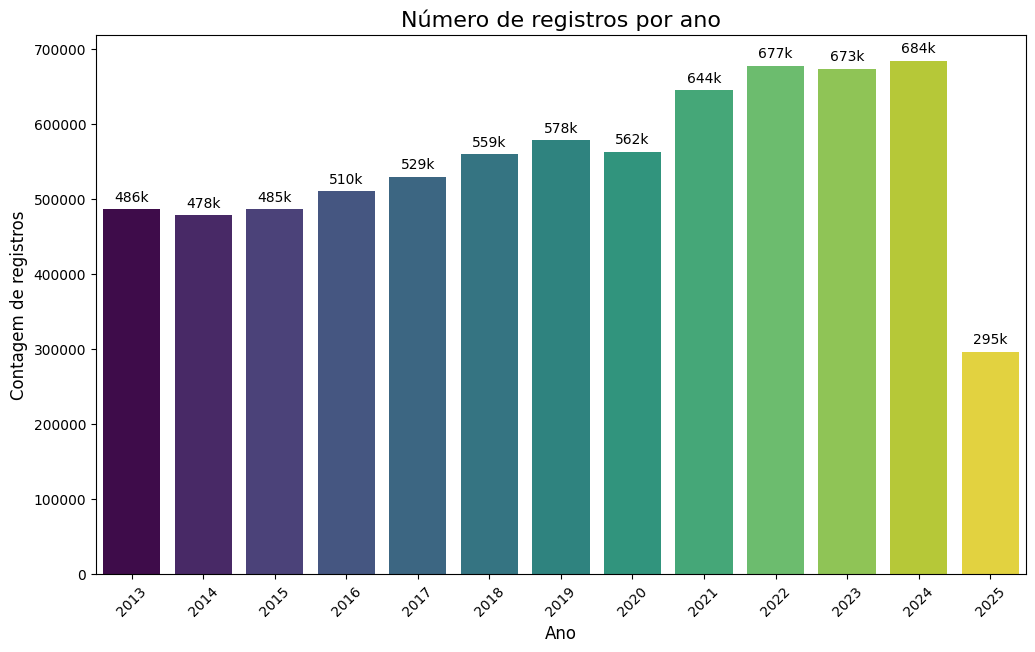

In [10]:
plt.figure(figsize=(12, 7))

ax = sns.countplot(data=data, x="YEAR", palette="viridis", legend=False, hue="YEAR")

plt.title("Número de registros por ano", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Contagem de registros", fontsize=12)
plt.xticks(rotation=45)

for p in ax.patches:
    ax.annotate(
        f"{int(p.get_height()/1e3)}k",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.show()

## 3.2 Distribuição dos dados por ativo

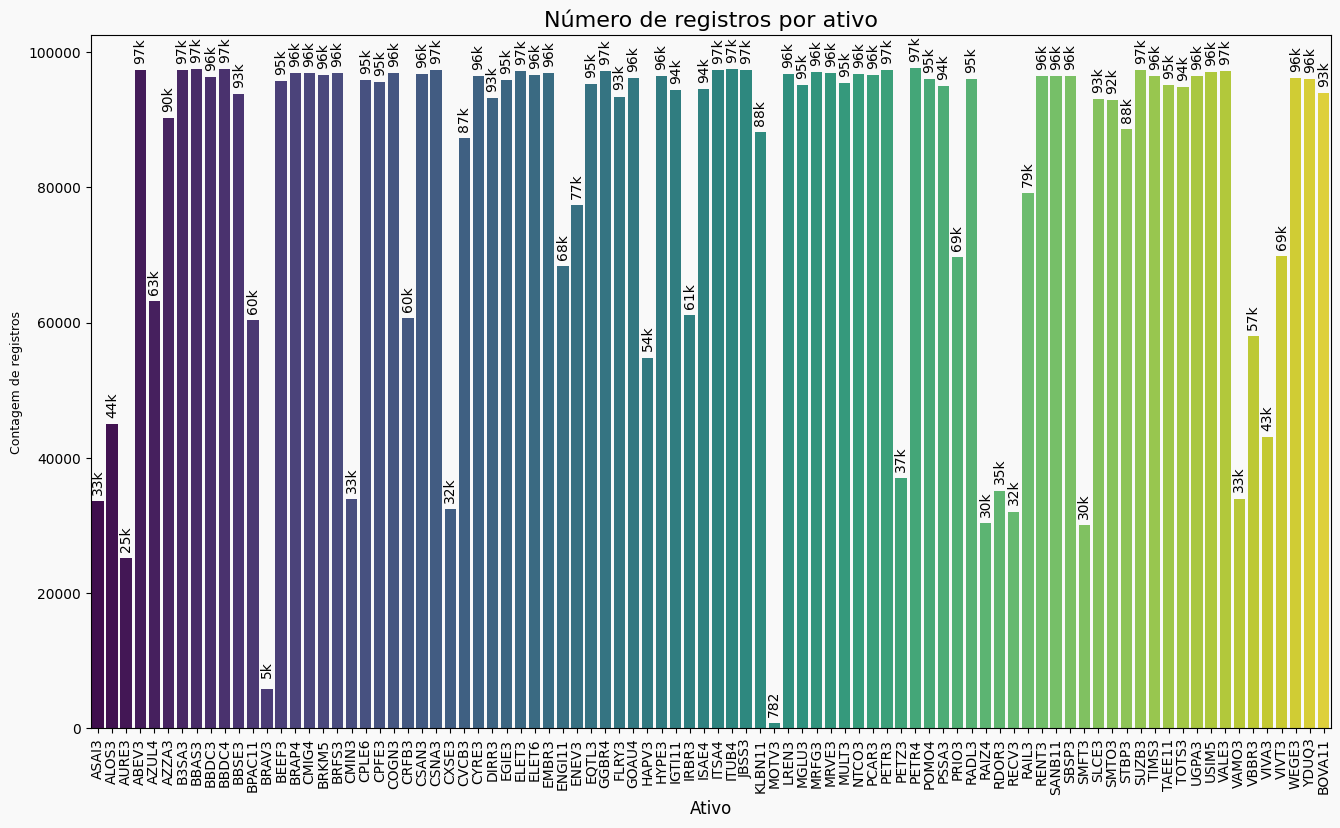

In [11]:
plt.figure(figsize=(16, 9))

ax = sns.countplot(data=data, x="NAME", palette="viridis", legend=False, hue="NAME")
ax.set_facecolor("#f9f9f9")
ax.figure.set_facecolor("#f9f9f9")

plt.title("Número de registros por ativo", fontsize=16)
plt.xlabel("Ativo", fontsize=12)
plt.ylabel("Contagem de registros", fontsize=9)
plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(
        (
            f"{int(p.get_height()/1e3)}k"
            if p.get_height() > 1000
            else f"{int(p.get_height())}"
        ),
        (p.get_x() + p.get_width() / 2.0, p.get_height() + 1000),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
        rotation=90,
    )

plt.show()

## 3.3 Distribuição temporal dos dados por ativo

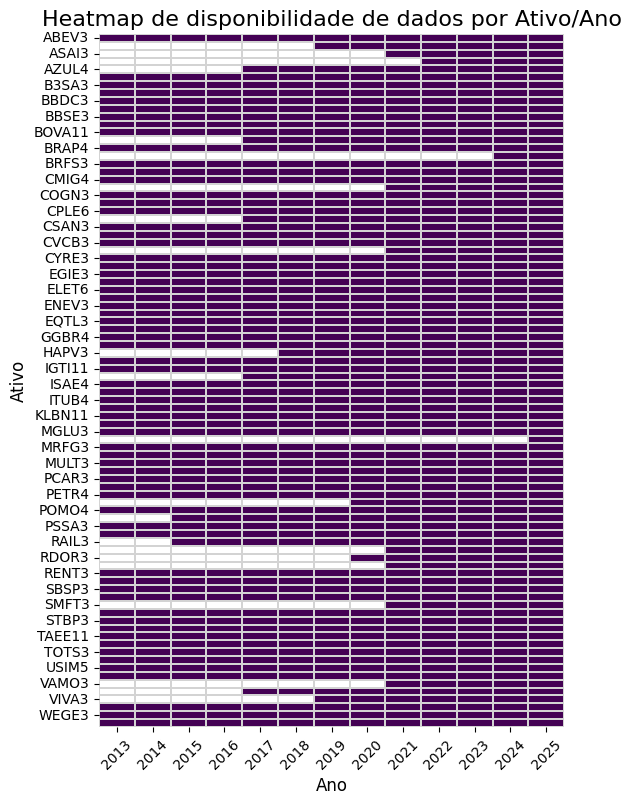

In [12]:
availability = data[["NAME", "YEAR"]].drop_duplicates()
availability["has_data"] = 1

heatmap_data = availability.pivot(index="NAME", columns="YEAR", values="has_data")

plt.figure(figsize=(6, 9))
ax = sns.heatmap(
    heatmap_data,
    cmap="viridis",
    cbar=False,
    linewidths=0.1,
    linecolor="lightgray",
)

# ax.set_facecolor("#f9f9f9")
# ax.figure.set_facecolor("#f9f9f9")

plt.title("Heatmap de disponibilidade de dados por Ativo/Ano", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Ativo", fontsize=12)
plt.xticks(rotation=45)

plt.show()

## 3.4 Distribuição das variáveis OHLCV

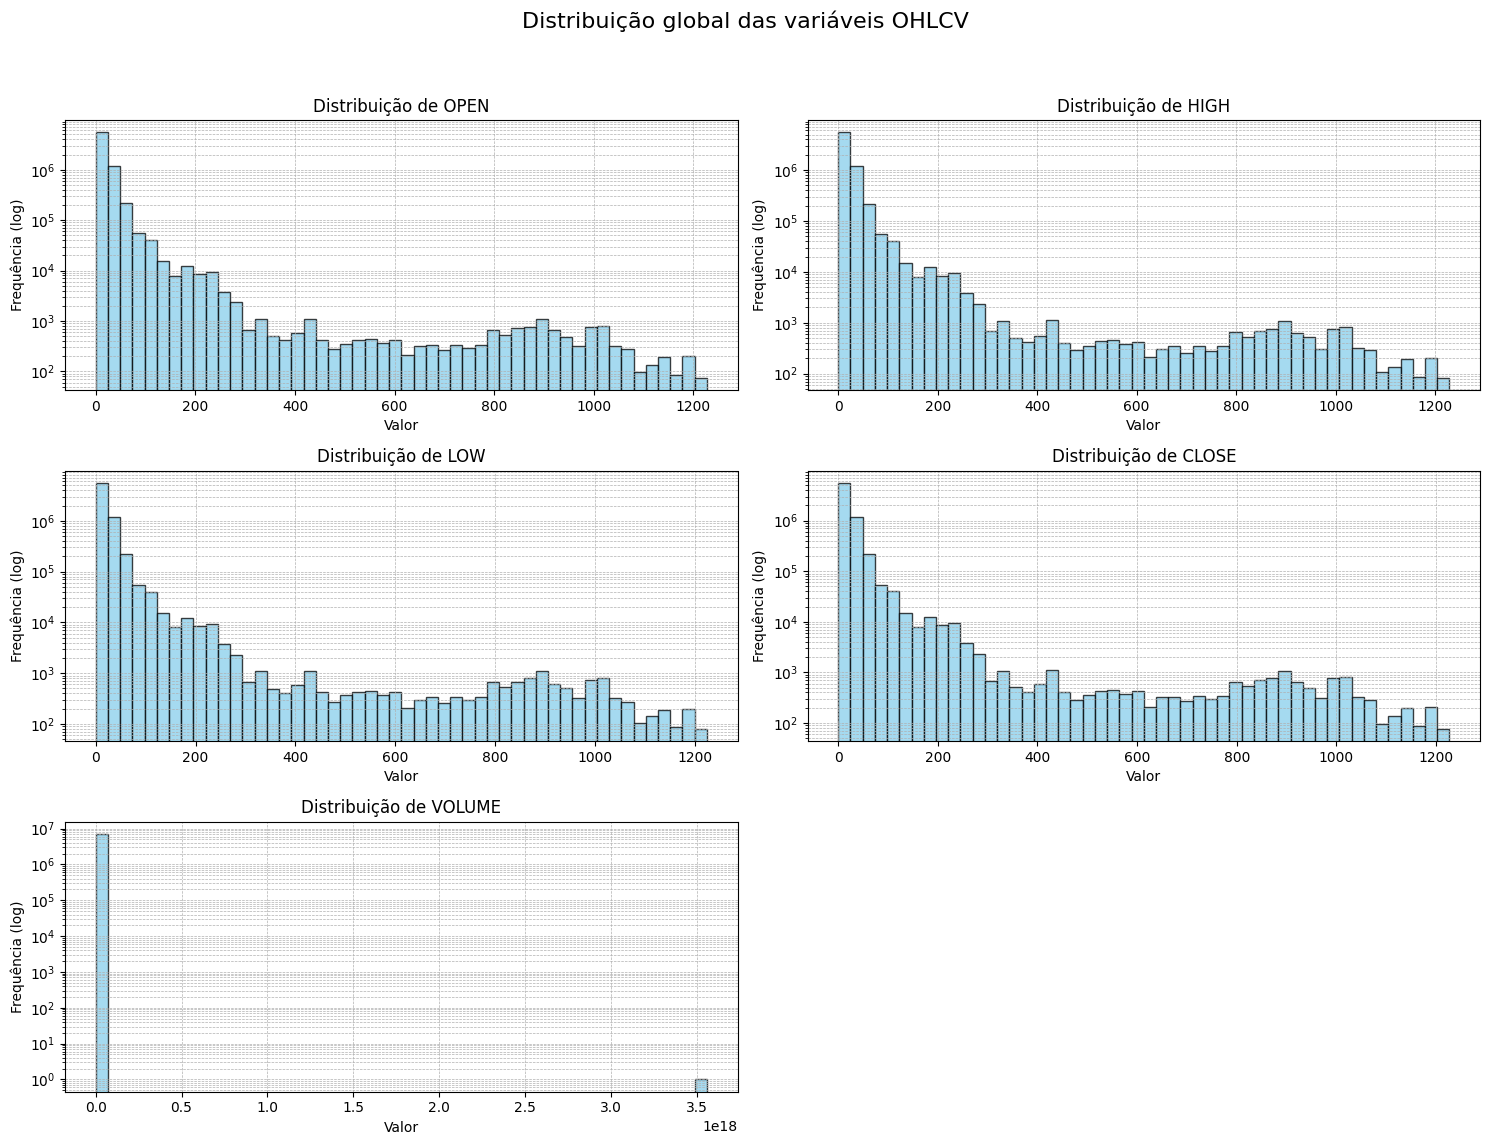

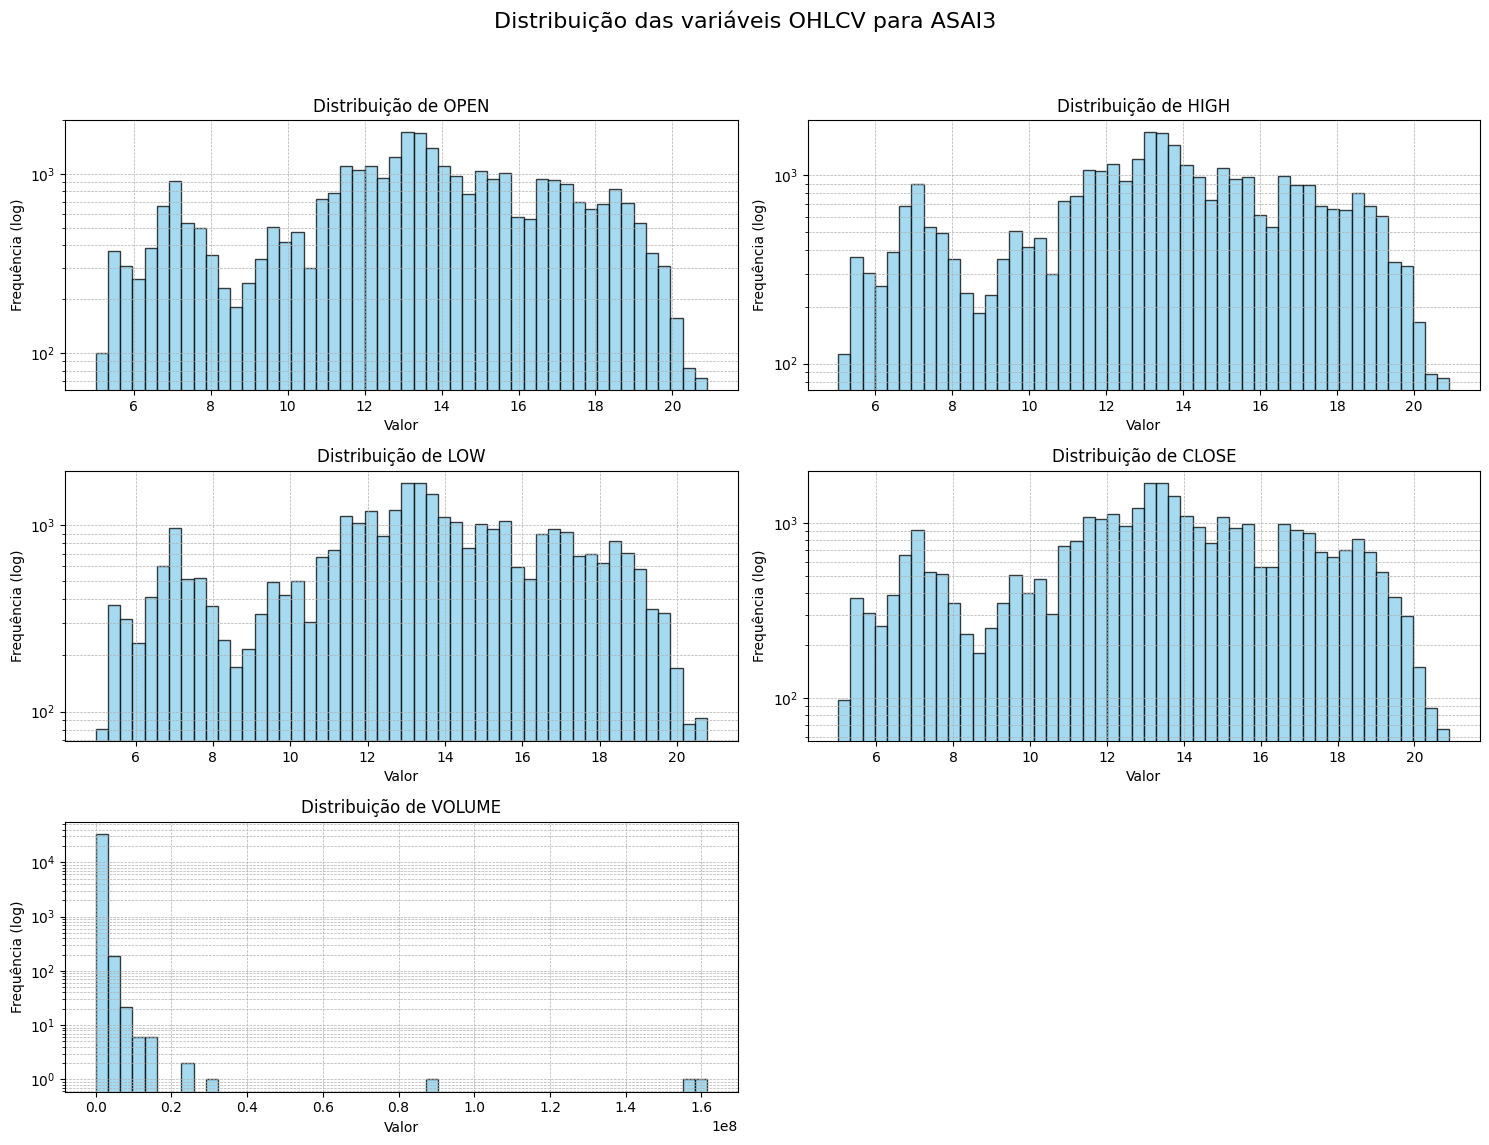

In [13]:
def plot_ohlcv_hists(df, stock_name=None):
    numeric_cols = ["OPEN", "HIGH", "LOW", "CLOSE", "VOLUME"]
    fig_title = (
        f"Distribuição das variáveis OHLCV para {stock_name}"
        if stock_name
        else "Distribuição global das variáveis OHLCV"
    )
    hist_df = df.copy()
    hist_df = df[df["NAME"] == stock_name] if stock_name else df

    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    fig.suptitle(fig_title, fontsize=16)

    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        if col in df.columns:
            ax = axes[i]

            ax.hist(
                hist_df[col].dropna(),
                bins=50,
                alpha=0.75,
                color="skyblue",
                edgecolor="black",
            )

            ax.set_yscale("log")

            ax.set_title(f"Distribuição de {col}", fontsize=12)
            ax.set_xlabel("Valor")
            ax.set_ylabel("Frequência (log)")
            ax.grid(True, which="both", linestyle="--", linewidth=0.5)
        else:

            axes[i].set_visible(False)

    if len(numeric_cols) < len(axes):
        for i in range(len(numeric_cols), len(axes)):
            fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


plot_ohlcv_hists(data)
plot_ohlcv_hists(data, "ASAI3")

## 3.5 Resumo estatístico das variáveis OHLCV

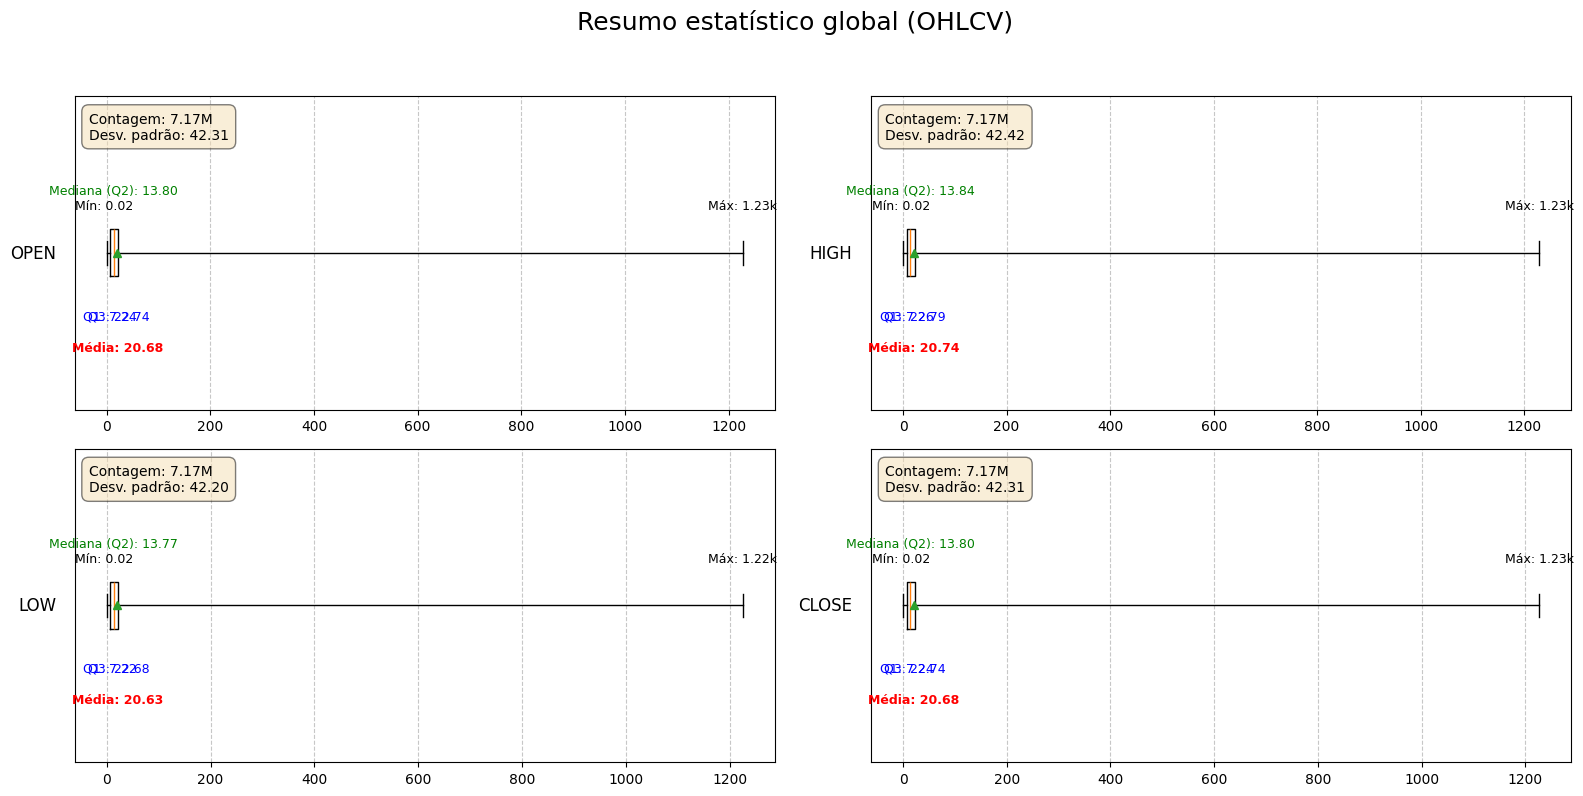

In [14]:
def plot_stat_summary(df, stock_name=None, plot_cols=None):
    fig_title = (
        f"Distribuição das variáveis OHLCV para {stock_name}"
        if stock_name
        else "Resumo estatístico global (OHLCV)"
    )
    summary_df = df.copy()
    summary_df = df[df["NAME"] == stock_name] if stock_name else df

    if plot_cols is None:
        plot_cols = ["OPEN", "HIGH", "LOW", "CLOSE"]

    summary_df = summary_df[plot_cols].describe()
    cols_to_plot = summary_df.columns

    nrows = (len(cols_to_plot) + 1) // 2
    fig, axes = plt.subplots(nrows, 2, figsize=(16, 8))

    fig.suptitle(fig_title, fontsize=18, y=1.02)

    for ax, col in zip(axes.flatten(), cols_to_plot):
        stats = summary_df[col]

        bp_stats = [
            {
                "med": stats["50%"],
                "q1": stats["25%"],
                "q3": stats["75%"],
                "whislo": stats["min"],
                "whishi": stats["max"],
                "mean": stats["mean"],
                "label": col,
            }
        ]

        ax.bxp(bp_stats, showmeans=True, vert=False, showfliers=False)

        y_pos = 1

        def format_value(val):
            if abs(val) > 1e9:
                return f"{val/1e9:.2f}B"
            if abs(val) > 1e6:
                return f"{val/1e6:.2f}M"
            if abs(val) > 1e3:
                return f"{val/1e3:.2f}k"
            return f"{val:.2f}"

        ax.text(
            np.log(stats["min"]),
            y_pos + 0.15,
            f"Mín: {format_value(stats['min'])}",
            va="center",
            ha="center",
            fontsize=9,
        )
        ax.text(
            stats["25%"],
            y_pos - 0.2,
            f"Q1: {format_value(stats['25%'])}",
            va="center",
            ha="center",
            fontsize=9,
            color="blue",
        )
        ax.text(
            stats["50%"],
            y_pos + 0.2,
            f"Mediana (Q2): {format_value(stats['50%'])}",
            va="center",
            ha="center",
            fontsize=9,
            color="green",
        )
        ax.text(
            stats["mean"],
            y_pos - 0.3,
            f"Média: {format_value(stats['mean'])}",
            va="center",
            ha="center",
            fontsize=9,
            color="red",
            weight="bold",
        )
        ax.text(
            stats["75%"],
            y_pos - 0.2,
            f"Q3: {format_value(stats['75%'])}",
            va="center",
            ha="center",
            fontsize=9,
            color="blue",
        )
        ax.text(
            stats["max"],
            y_pos + 0.15,
            f"Máx: {format_value(stats['max'])}",
            va="center",
            ha="center",
            fontsize=9,
        )

        text_str = f"Contagem: {format_value(stats['count'])}\nDesv. padrão: {format_value(stats['std'])}"
        ax.text(
            0.02,
            0.95,
            text_str,
            transform=ax.transAxes,
            fontsize=10,
            verticalalignment="top",
            bbox=dict(boxstyle="round,pad=0.5", fc="wheat", alpha=0.5),
        )

        ax.set_yticklabels([])
        ax.set_ylabel(
            col, fontsize=12, rotation=0, ha="right", va="center", labelpad=10
        )
        ax.tick_params(axis="y", length=0)
        ax.grid(axis="x", linestyle="--", alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


plot_stat_summary(data)

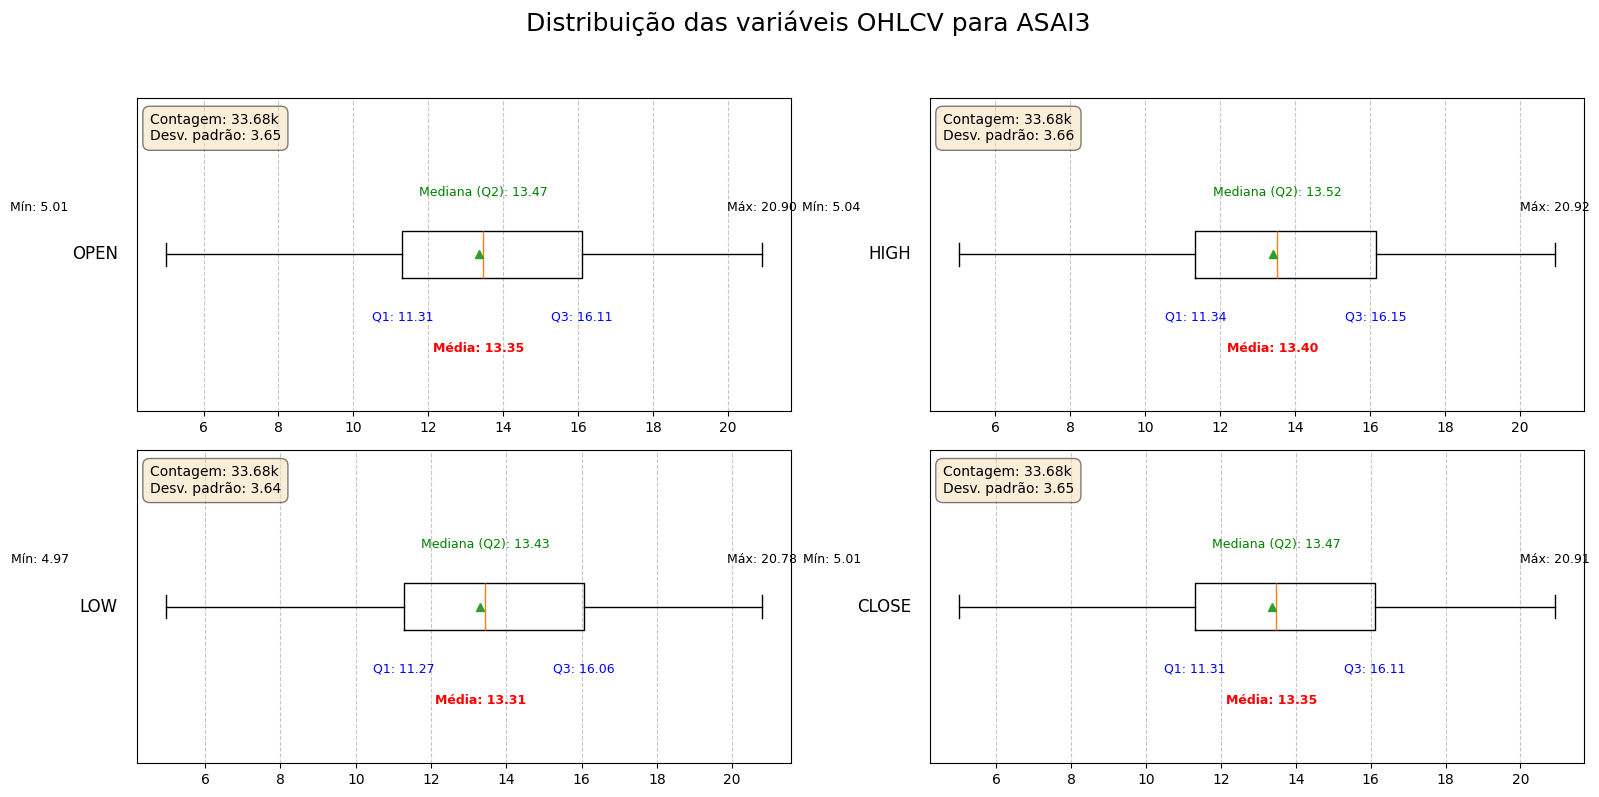

In [15]:
plot_stat_summary(data, "ASAI3")

## 3.6 Distribuição estatística das variáveis OHLCV

<Figure size 2000x1000 with 0 Axes>

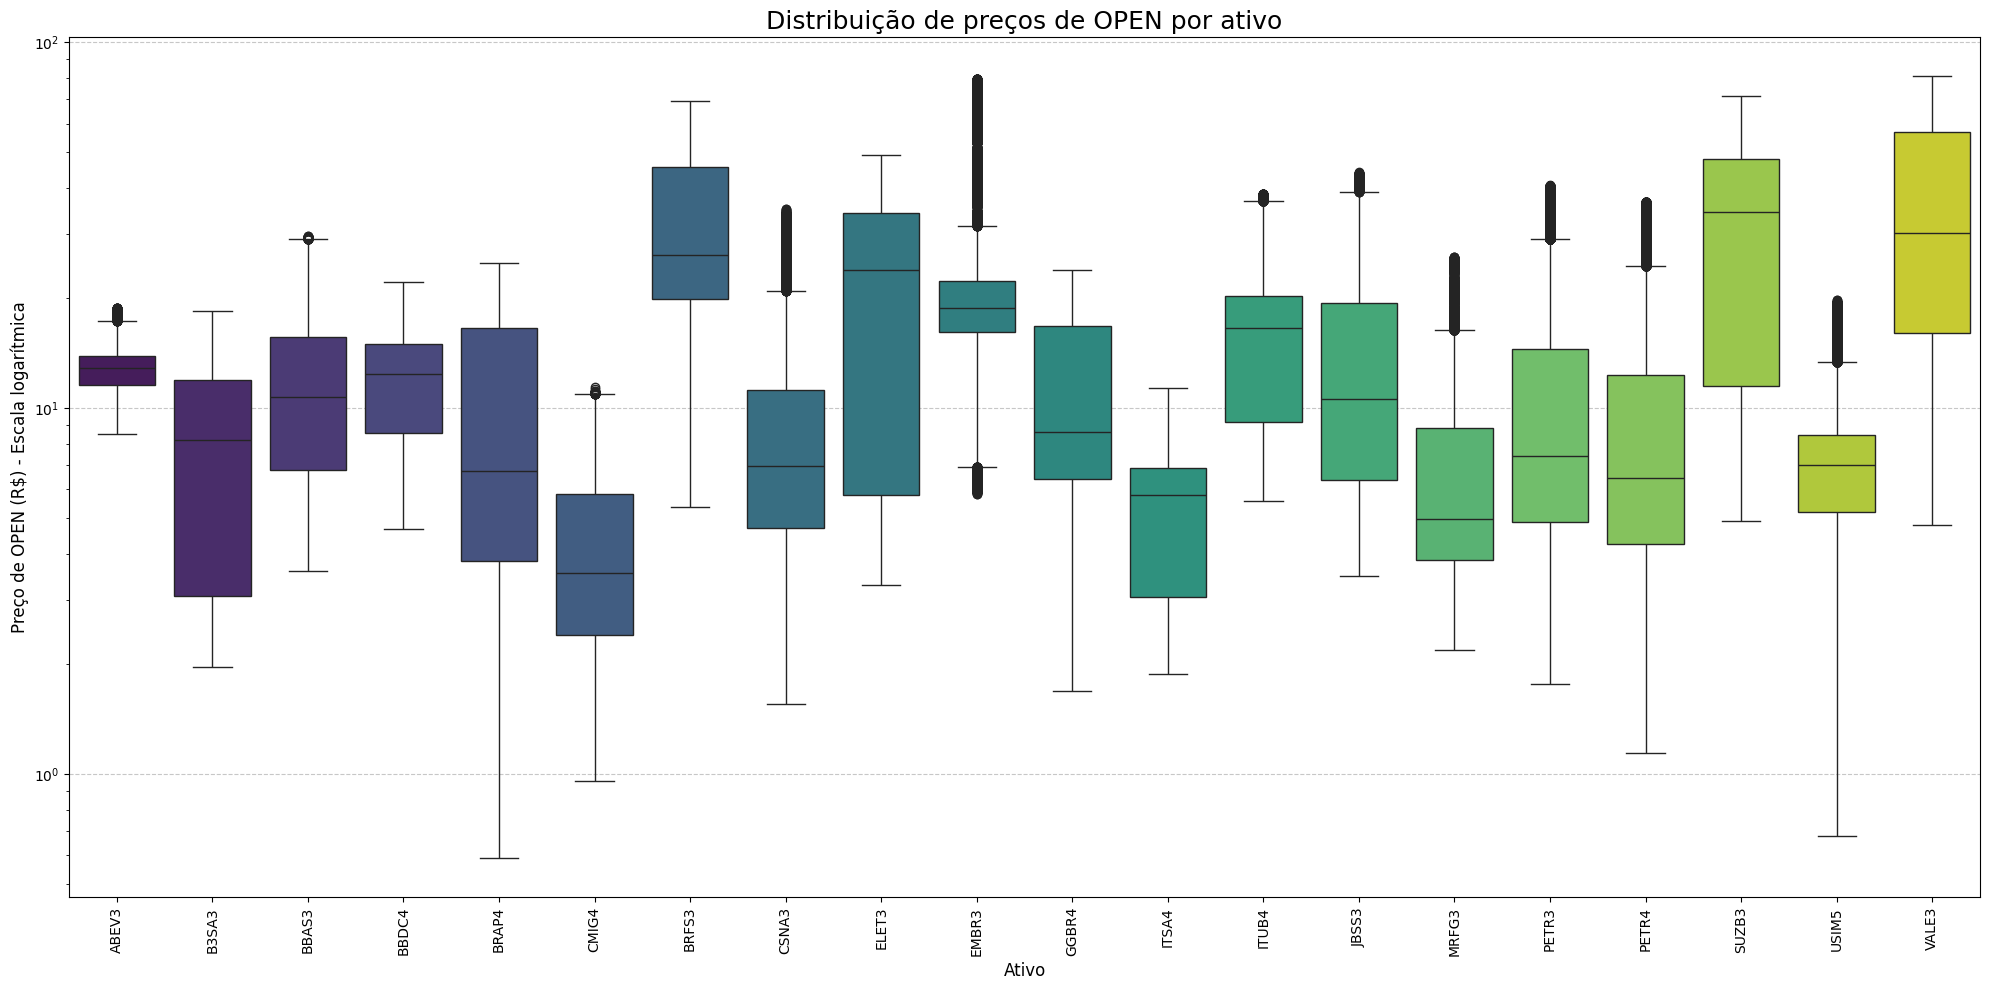

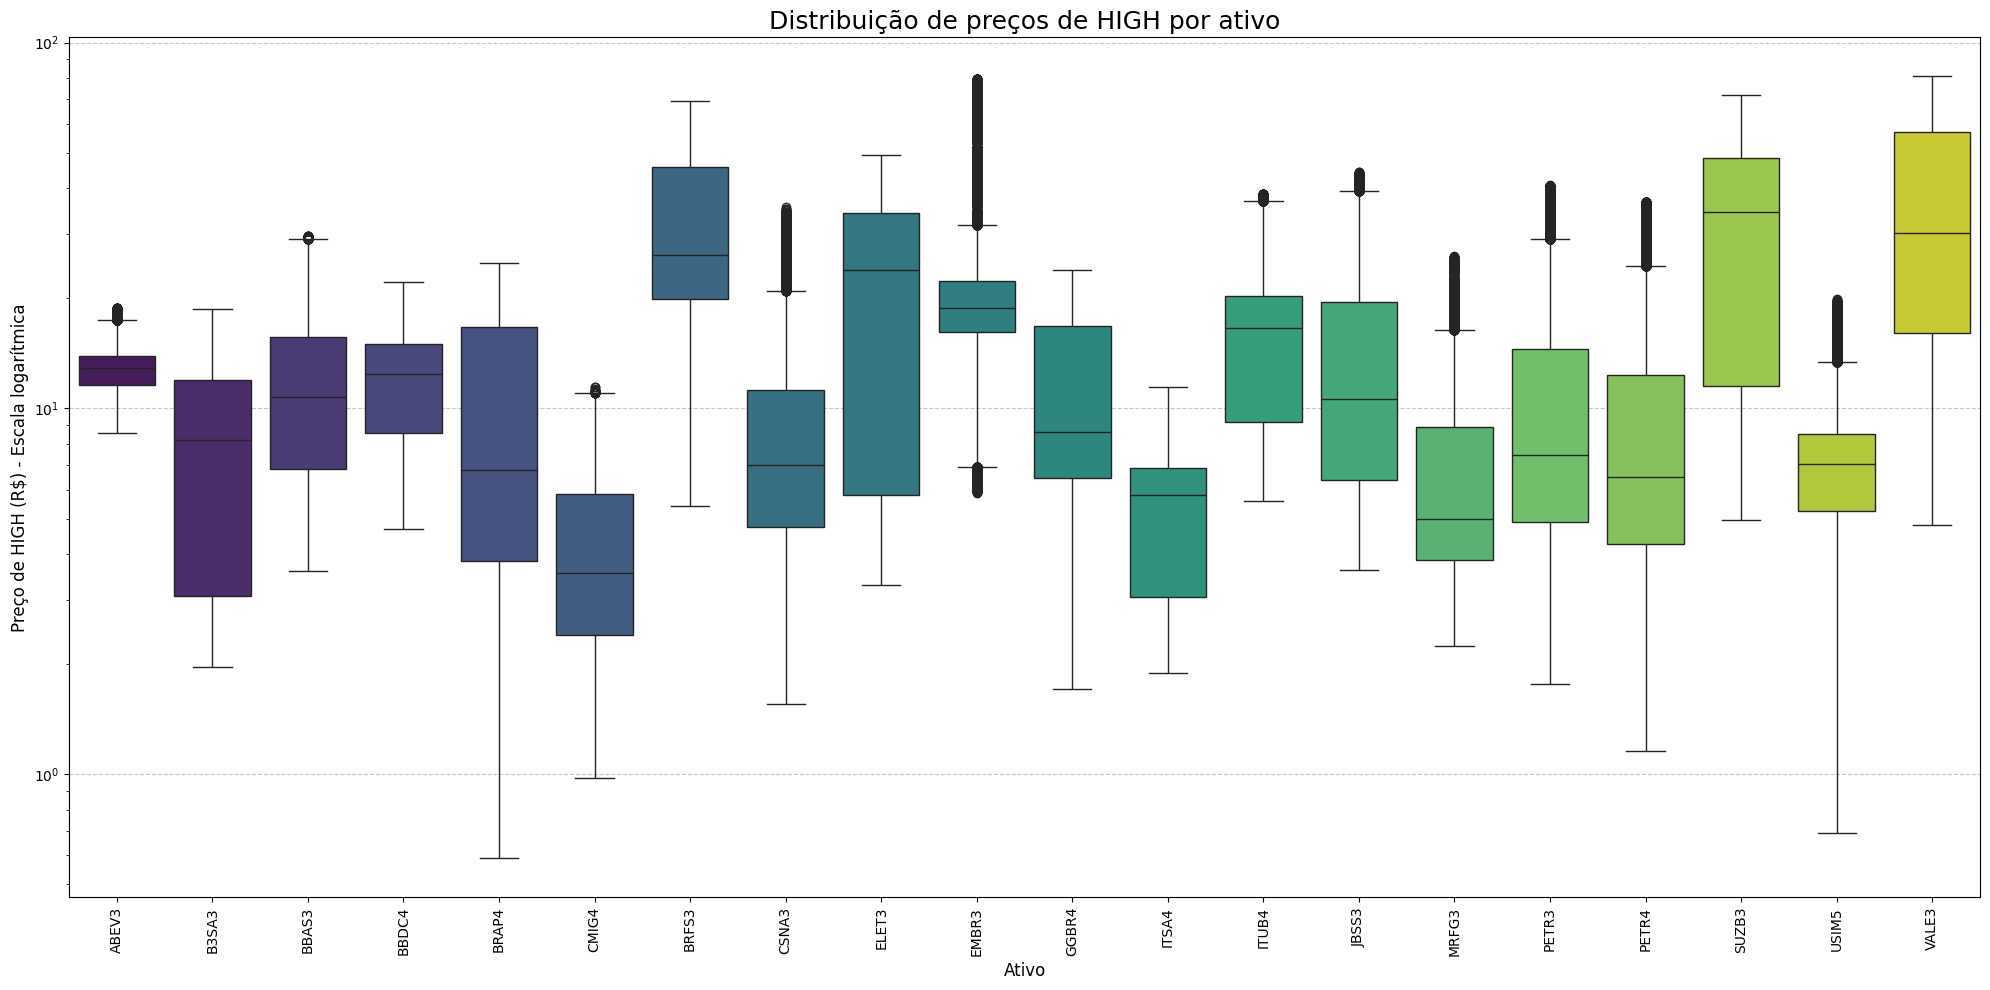

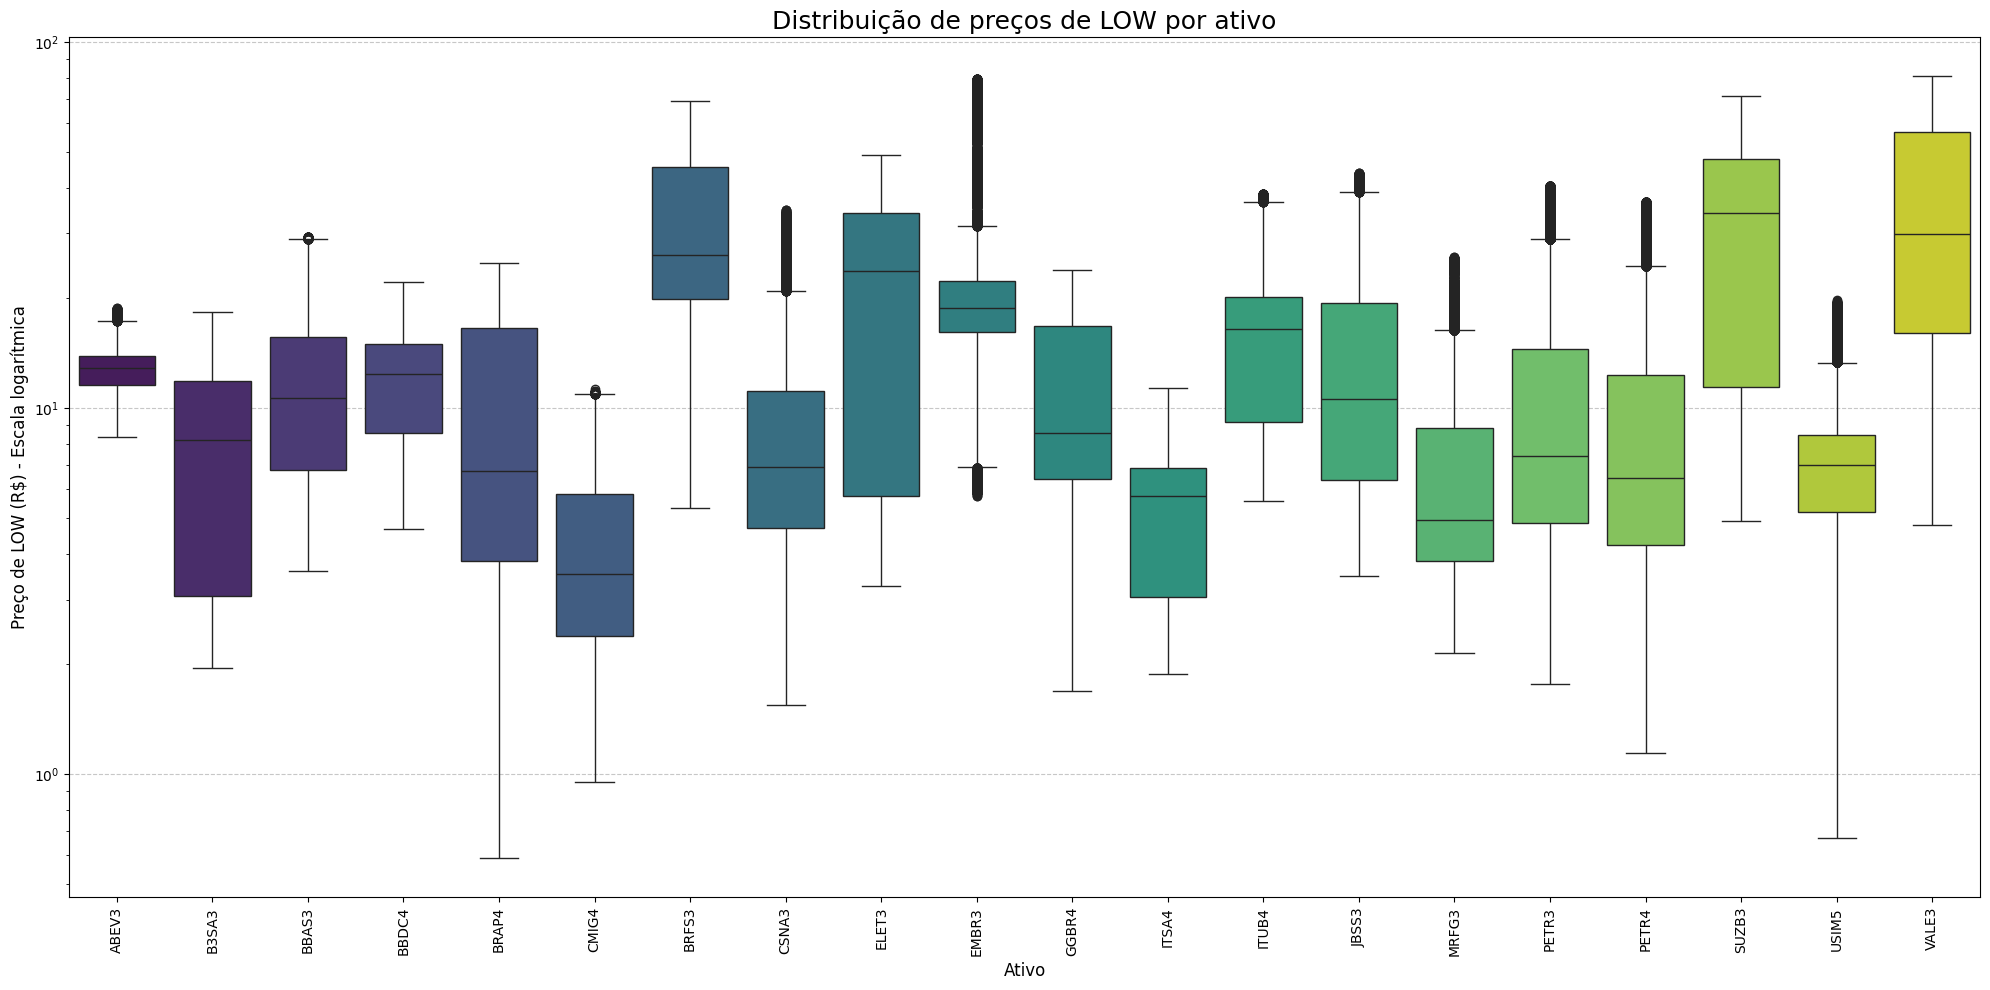

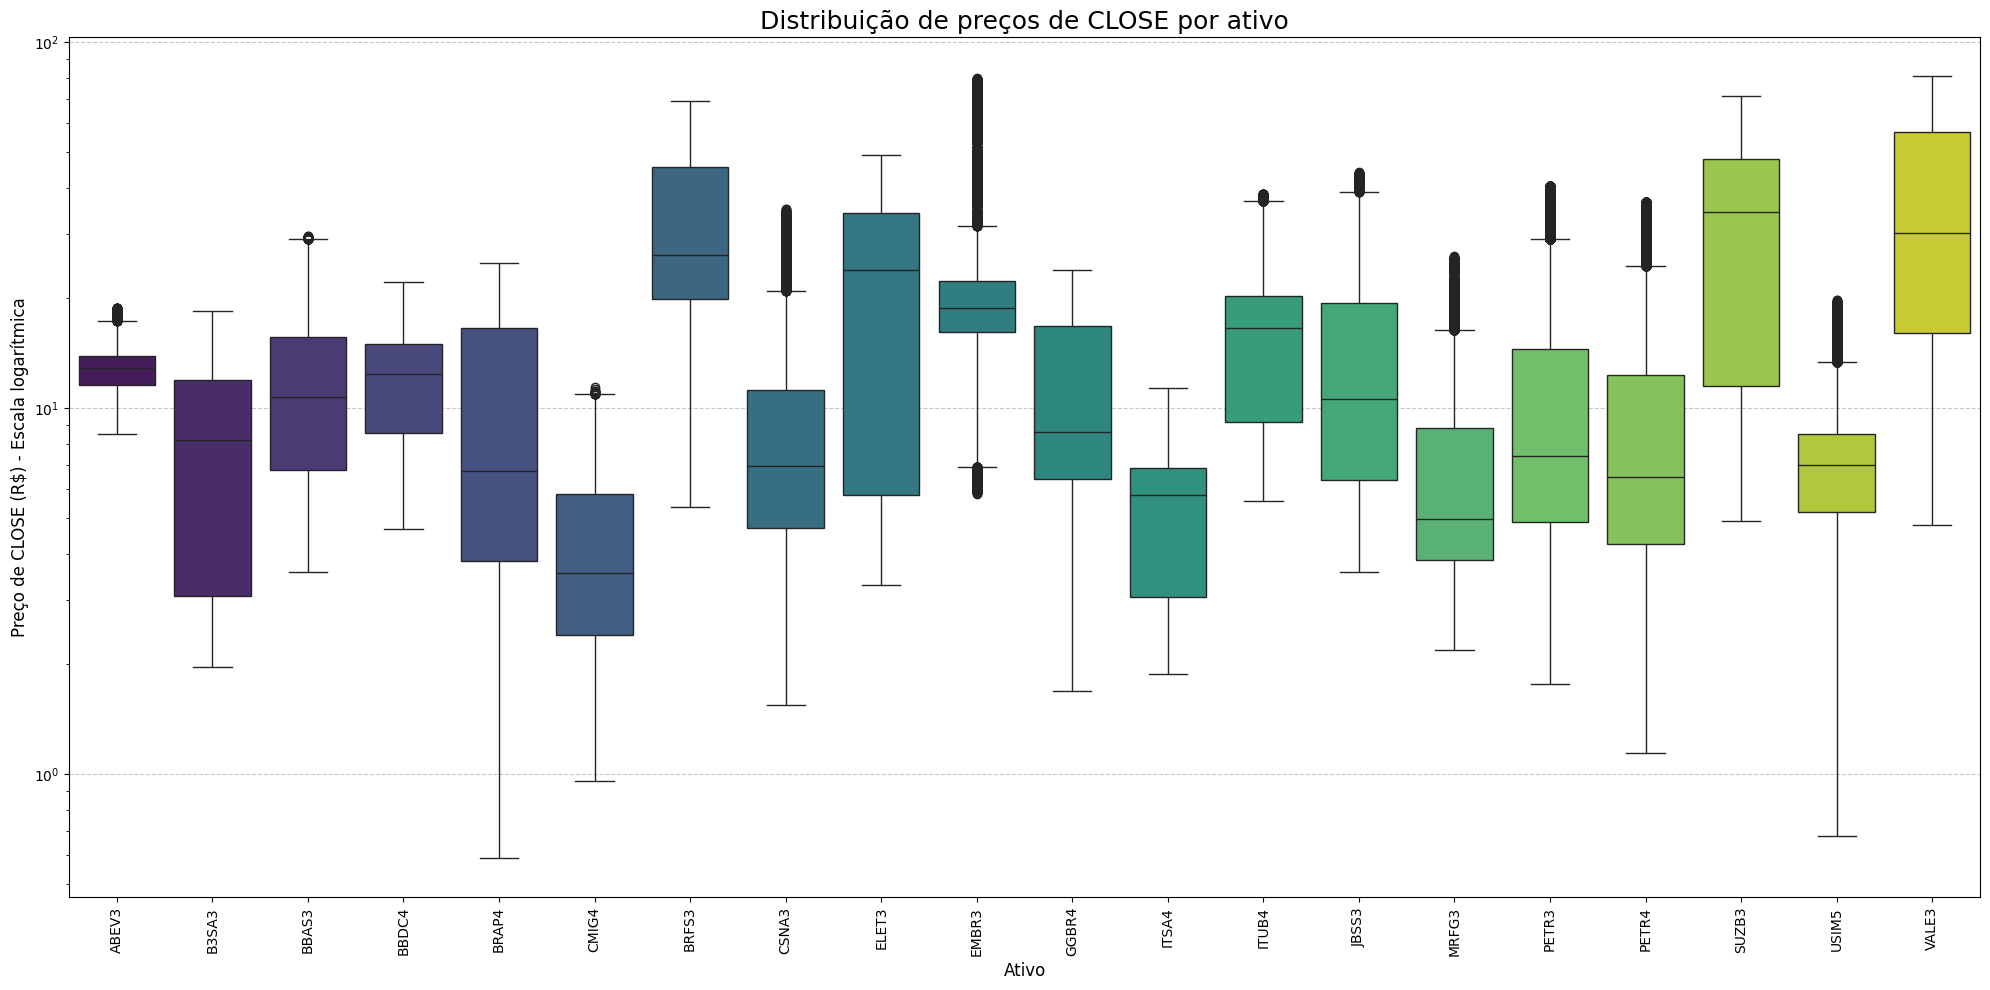

In [16]:
top_stocks = data["NAME"].value_counts().nlargest(20).index
data_top_stocks = data[data["NAME"].isin(top_stocks)]

plt.figure(figsize=(20, 10))
for col in ["OPEN", "HIGH", "LOW", "CLOSE"]:
    plt.figure(figsize=(20, 10))
    ax = sns.boxplot(
        data=data_top_stocks,
        x="NAME",
        y=col,
        palette="viridis",
        legend=False,
        hue="NAME",
    )

    ax.set_yscale("log")

    ax.set_title(f"Distribuição de preços de {col} por ativo", fontsize=18)
    ax.set_xlabel("Ativo", fontsize=12)
    ax.set_ylabel(f"Preço de {col} (R$) - Escala logarítmica", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

## 3.7 Análise da variação percentual diária

C:\Users\lucas\AppData\Local\Temp\ipykernel_28372\2994791322.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = daily_close.groupby(level="NAME").pct_change().dropna()


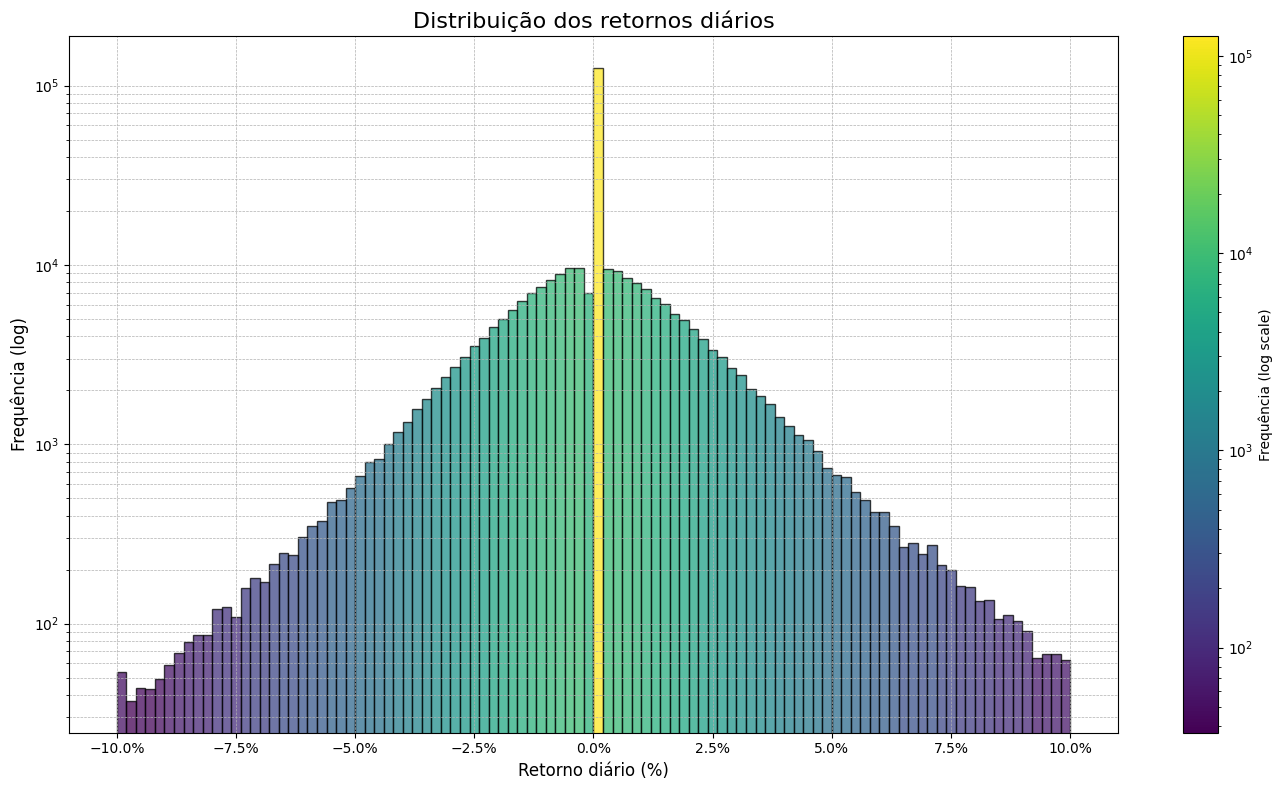

In [17]:
if not pd.api.types.is_datetime64_any_dtype(data["TIMESTAMP"]):
    data["TIMESTAMP"] = pd.to_datetime(data["TIMESTAMP"])

data_indexed = data.set_index("TIMESTAMP")
daily_close = data_indexed.groupby("NAME")["CLOSE"].resample("D").last()
daily_returns = daily_close.groupby(level="NAME").pct_change().dropna()
daily_returns = daily_returns.replace([np.inf, -np.inf], np.nan).dropna()

fig, ax = plt.subplots(figsize=(14, 8))

num_bins = 100
plot_range = (-0.1, 0.1)

n, bins, patches = ax.hist(
    daily_returns, bins=num_bins, range=plot_range, alpha=0.75, edgecolor="black"
)

cmap = plt.colormaps["viridis"]

norm = mcolors.LogNorm(vmin=np.min(n[n > 0]) if np.any(n > 0) else 1, vmax=np.max(n))

for count, patch in zip(n, patches):
    if count > 0:
        color = cmap(norm(count))
        patch.set_facecolor(color)
    else:
        patch.set_facecolor("lightgray")

ax.set_yscale("log")

ax.set_title("Distribuição dos retornos diários", fontsize=16)
ax.set_xlabel("Retorno diário (%)", fontsize=12)
ax.set_ylabel("Frequência (log)", fontsize=12)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

ax.xaxis.set_major_formatter(PercentFormatter(1))

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, label="Frequência (log scale)")

plt.tight_layout()
plt.show()

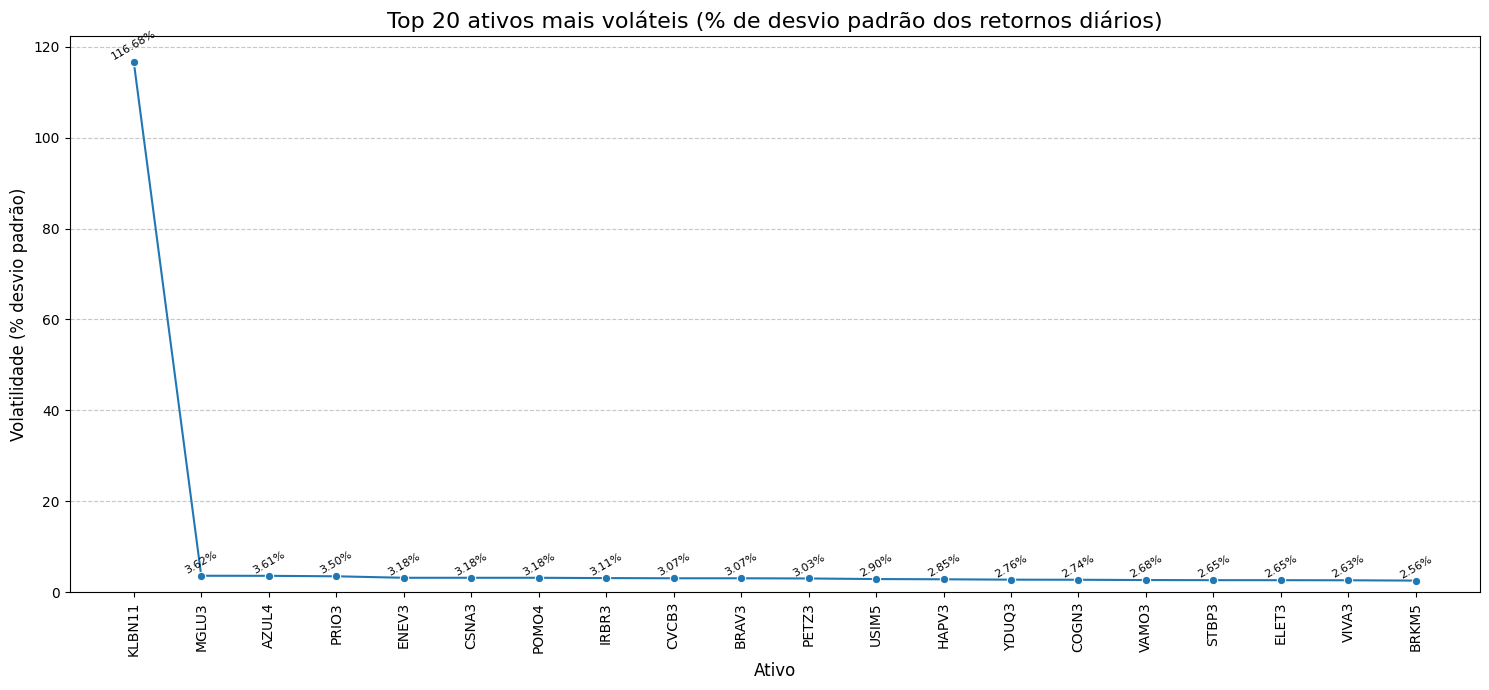

In [18]:
volatility = (
    daily_returns.groupby(level="NAME").std().sort_values(ascending=False).copy()
)
volatility_percent = pd.DataFrame(volatility * 100)
volatility_df = volatility_percent.reset_index()
volatility_df.columns = ["NAME", "VOLAT"]
volat_top_n = 20
top_volatil = volatility_df.sort_values(by="VOLAT", ascending=False).head(volat_top_n)

plt.figure(figsize=(15, 7))
ax = sns.lineplot(
    data=top_volatil,
    x="NAME",
    y="VOLAT",
    marker="o",
    sort=False,
)

for index, row in top_volatil.iterrows():
    ax.text(
        x=row["NAME"],
        y=row["VOLAT"] + 0.05,
        s=f"{row['VOLAT']:.2f}%",
        ha="center",
        va="bottom",
        fontsize=8,
        rotation=30,
    )

plt.title(
    f"Top {volat_top_n} ativos mais voláteis (% de desvio padrão dos retornos diários)",
    fontsize=16,
)
plt.xlabel("Ativo", fontsize=12)
plt.ylabel("Volatilidade (% desvio padrão)", fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ylim(bottom=0)

plt.tight_layout()
plt.show()

# 4. Coleta de indicadores macroeconômicos

In [19]:
for indicator in ["ibc_br", "ipea_camb", "ipea_selic", "ipea_ipca", "ipea_exp_ipca"]:
    print(f"Indicador: {indicator}")
    df = pd.read_csv(f"data/{indicator}.csv")
    display(df.info())

Indicador: ibc_br
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          152 non-null    object 
 1   IBC_HEADLINE  152 non-null    float64
 2   IBC_AGRO      152 non-null    float64
 3   IBC_INDUSTRY  152 non-null    float64
 4   IBC_SERVICES  152 non-null    float64
 5   IBC_TAXES     152 non-null    float64
 6   IBC_EX_AGRO   152 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.4+ KB


None

Indicador: ipea_camb
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODE    153 non-null    object 
 1   DATE    153 non-null    object 
 2   DAY     153 non-null    int64  
 3   MONTH   153 non-null    int64  
 4   YEAR    153 non-null    int64  
 5   VALUE   153 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.3+ KB


None

Indicador: ipea_selic
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4606 entries, 0 to 4605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODE    4606 non-null   object 
 1   DATE    4606 non-null   object 
 2   DAY     4606 non-null   int64  
 3   MONTH   4606 non-null   int64  
 4   YEAR    4606 non-null   int64  
 5   VALUE   4606 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 216.0+ KB


None

Indicador: ipea_ipca
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODE    153 non-null    object 
 1   DATE    153 non-null    object 
 2   DAY     153 non-null    int64  
 3   MONTH   153 non-null    int64  
 4   YEAR    153 non-null    int64  
 5   VALUE   153 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.3+ KB


None

Indicador: ipea_exp_ipca
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CODE    153 non-null    object 
 1   DATE    153 non-null    object 
 2   DAY     153 non-null    int64  
 3   MONTH   153 non-null    int64  
 4   YEAR    153 non-null    int64  
 5   VALUE   153 non-null    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 7.3+ KB


None

In [20]:
def load_macro_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"], utc=True)
    return df.set_index("DATE").sort_index()

## 4.1 Taxa SELIC

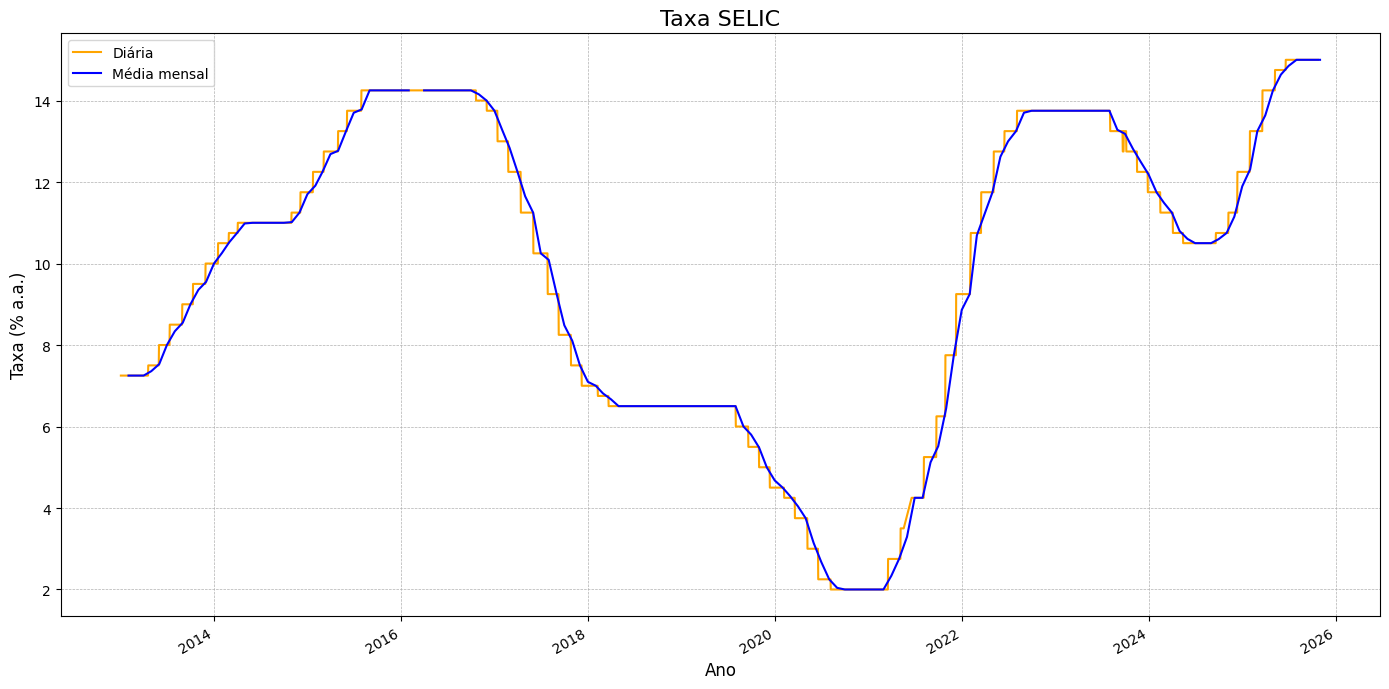

C:\Users\lucas\AppData\Local\Temp\ipykernel_28372\3537350759.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  selic_var_returns = selic_monthly.pct_change().dropna()


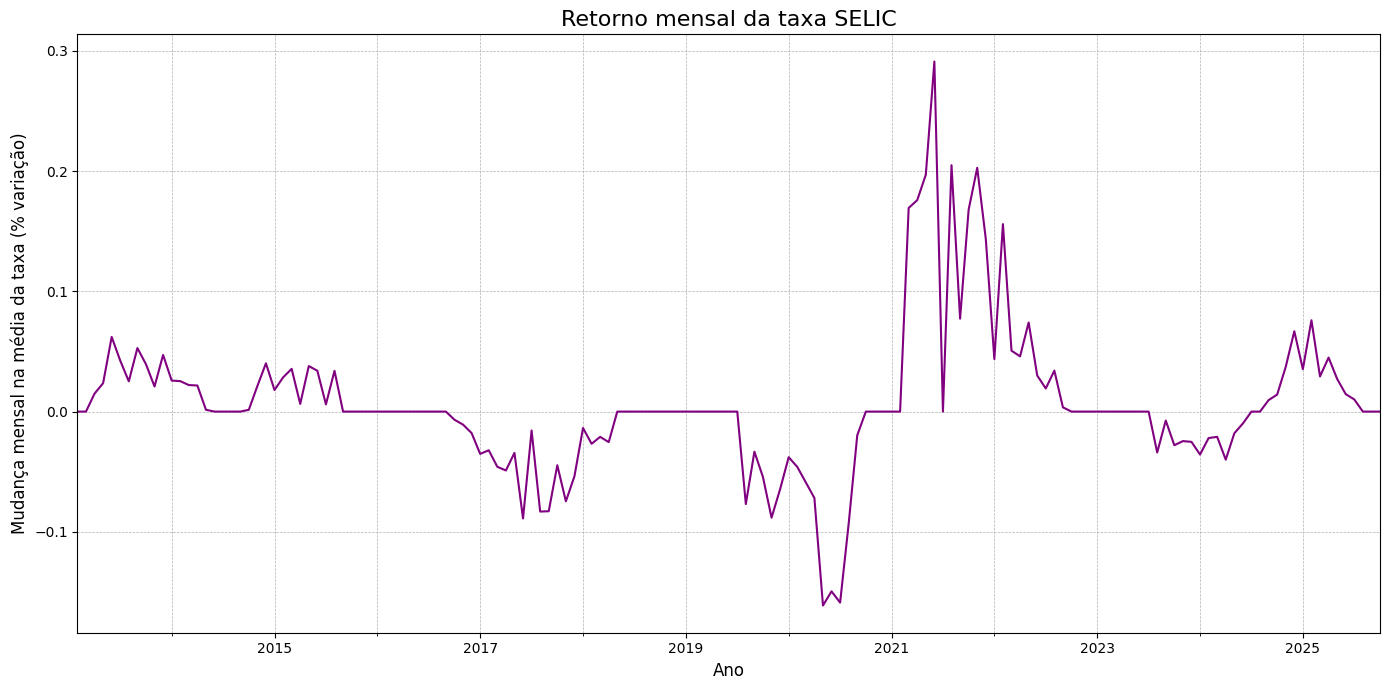

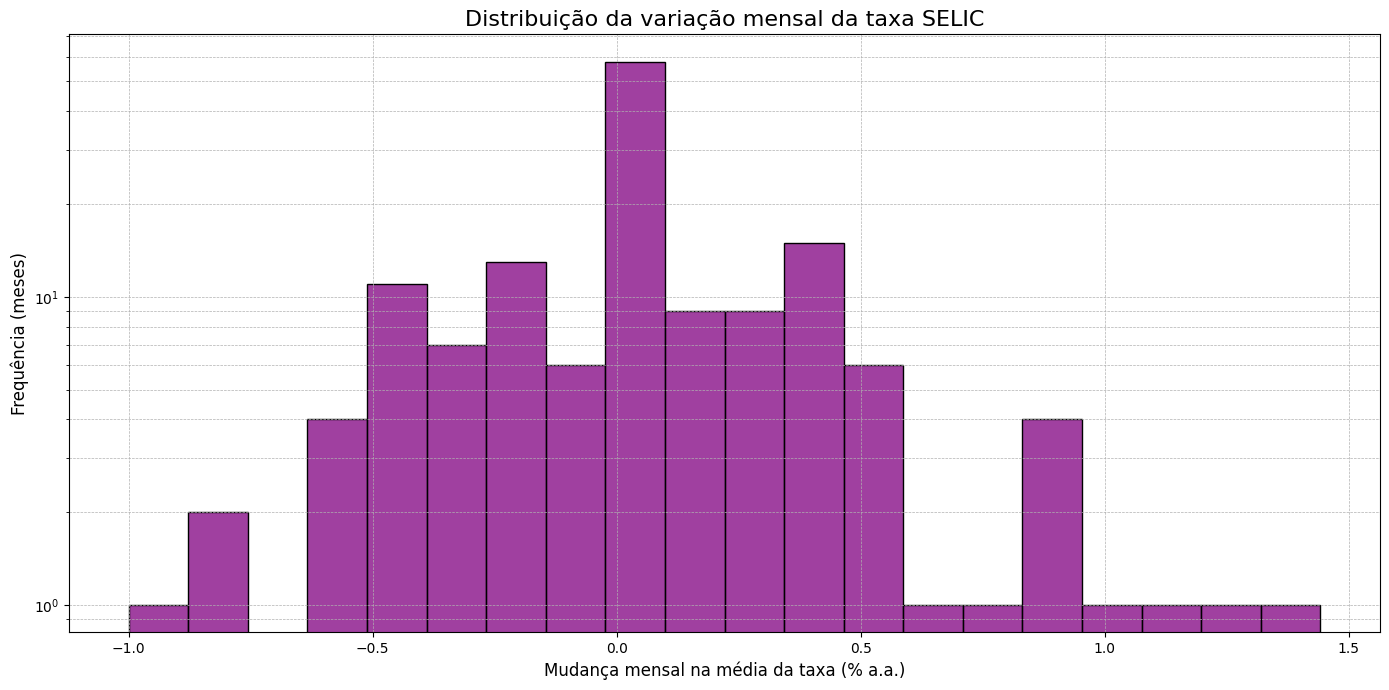

In [21]:
df_selic = load_macro_data("data/ipea_selic.csv")

df_selic_daily = df_selic["VALUE"]
df_selic_daily.name = "selic_daily"

selic_monthly = df_selic_daily.resample("ME").mean()
selic_monthly.name = "selic_monthly"

plt.figure(figsize=(14, 7))
df_selic_daily.plot(color="orange")
selic_monthly.plot(color="blue")
plt.title("Taxa SELIC", fontsize=16)
plt.legend(["Diária", "Média mensal"])
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Taxa (% a.a.)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

selic_var = selic_monthly.diff().dropna()
selic_var.name = "selic_var_monthly"

selic_var_returns = selic_monthly.pct_change().dropna()
selic_var_returns.name = "selic_var_monthly_returns"

plt.figure(figsize=(14, 7))
selic_var_returns.plot(color="purple")
plt.title("Retorno mensal da taxa SELIC", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Mudança mensal na média da taxa (% variação)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

min_val = selic_var.min()
max_val = selic_var.max()
if pd.notna(min_val) and pd.notna(max_val):
    bins = int((max_val - min_val) / 0.125) + 1
    if bins < 5 or bins > 100:
        bins = 30
else:
    bins = 30

plt.figure(figsize=(14, 7))
sns.histplot(selic_var, bins=bins, kde=False, color="purple", edgecolor="black")
plt.title("Distribuição da variação mensal da taxa SELIC", fontsize=16)
plt.xlabel("Mudança mensal na média da taxa (% a.a.)", fontsize=12)
plt.ylabel("Frequência (meses)", fontsize=12)
plt.yscale("log")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## 4.2 IPCA (inflação)

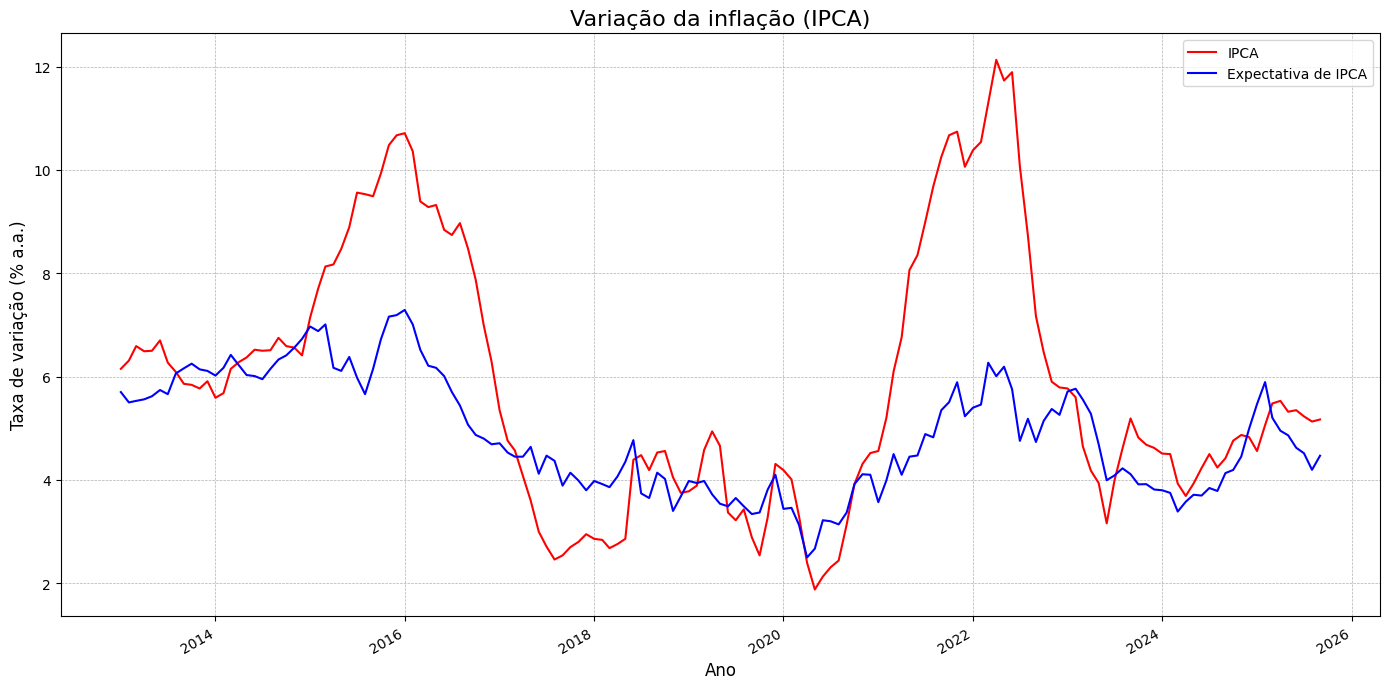

In [22]:
df_ipca = load_macro_data("data/ipea_ipca.csv")
df_exp_ipca = load_macro_data("data/ipea_exp_ipca.csv")

ipca_monthly_pct = df_ipca["VALUE"]
ipca_monthly_pct.name = "ipca_monthly_pct"

exp_ipca_monthly_pct = df_exp_ipca["VALUE"]
exp_ipca_monthly_pct.name = "exp_ipca_monthly_pct"

plt.figure(figsize=(14, 7))
ipca_monthly_pct.plot(color="red")
exp_ipca_monthly_pct.plot(color="blue")

plt.title("Variação da inflação (IPCA)", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Taxa de variação (% a.a.)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend(["IPCA", "Expectativa de IPCA"])
plt.tight_layout()
plt.show()

## 4.3 Taxa de câmbio

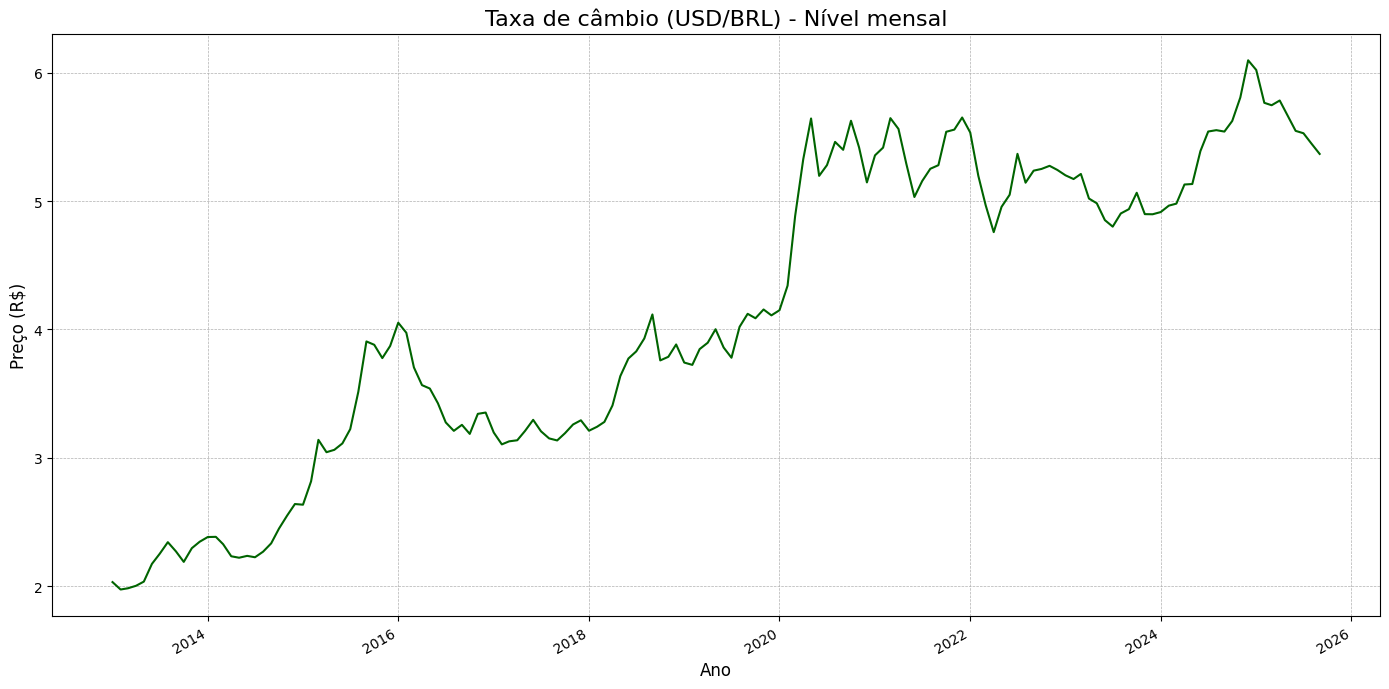

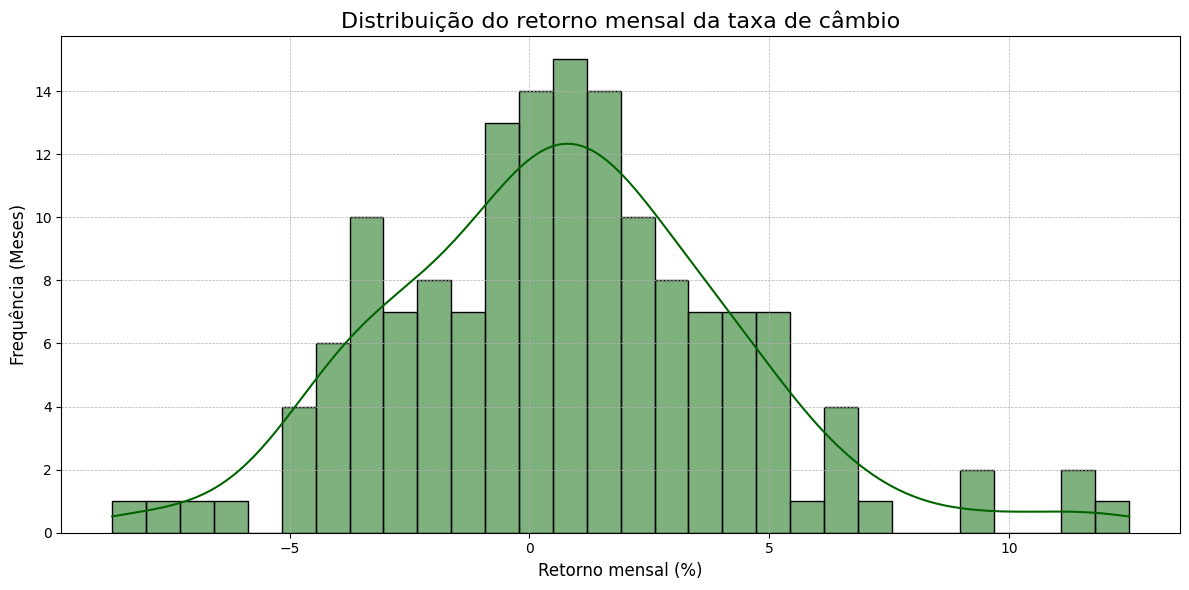

In [23]:
df_cambio = load_macro_data("data/ipea_camb.csv")
cambio_monthly_level = df_cambio["VALUE"]
cambio_monthly_level.name = "cambio_monthly_level"

plt.figure(figsize=(14, 7))
cambio_monthly_level.plot(color="darkgreen")
plt.title("Taxa de câmbio (USD/BRL) - Nível mensal", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Preço (R$)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

cambio_monthly_return_pct = cambio_monthly_level.pct_change()

cambio_monthly_return_pct = (cambio_monthly_return_pct * 100).dropna()
cambio_monthly_return_pct.name = "cambio_monthly_return_pct"


plt.figure(figsize=(12, 6))
sns.histplot(
    cambio_monthly_return_pct, bins=30, kde=True, color="darkgreen", edgecolor="black"
)
plt.title("Distribuição do retorno mensal da taxa de câmbio", fontsize=16)
plt.xlabel("Retorno mensal (%)", fontsize=12)
plt.ylabel("Frequência (Meses)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

## 4.1 IBC

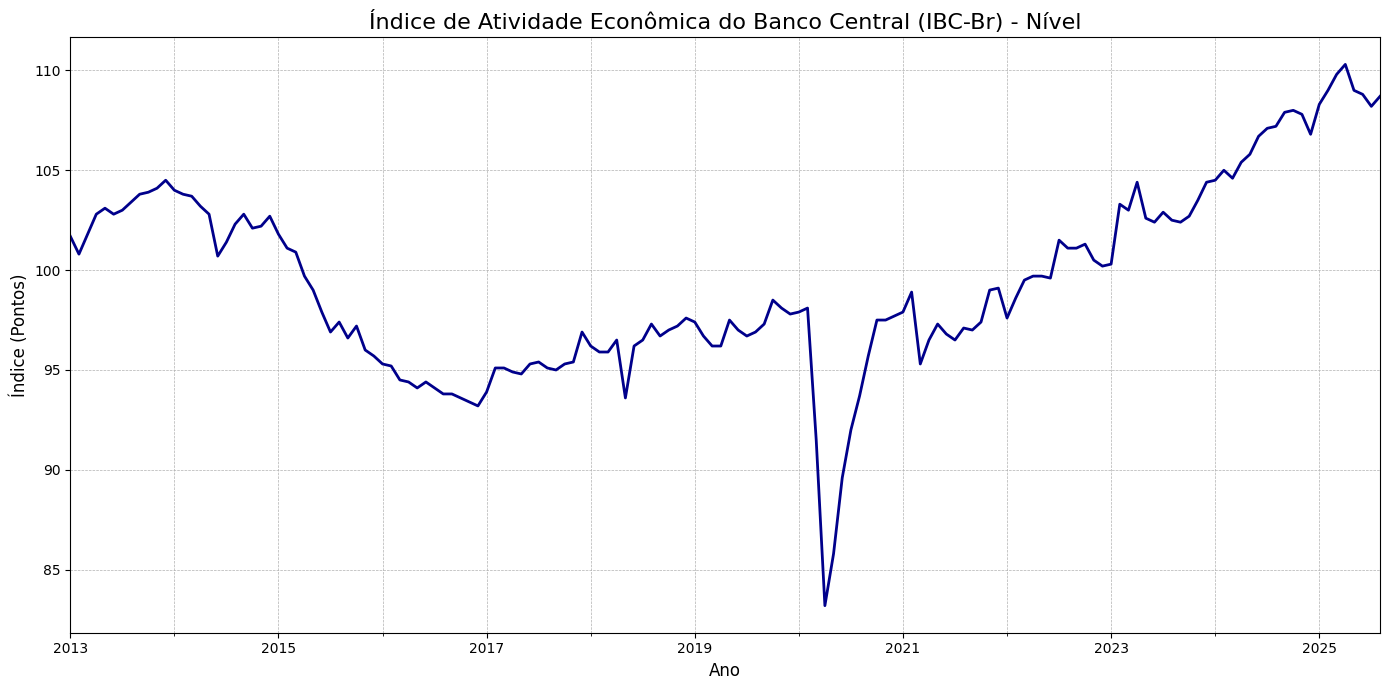

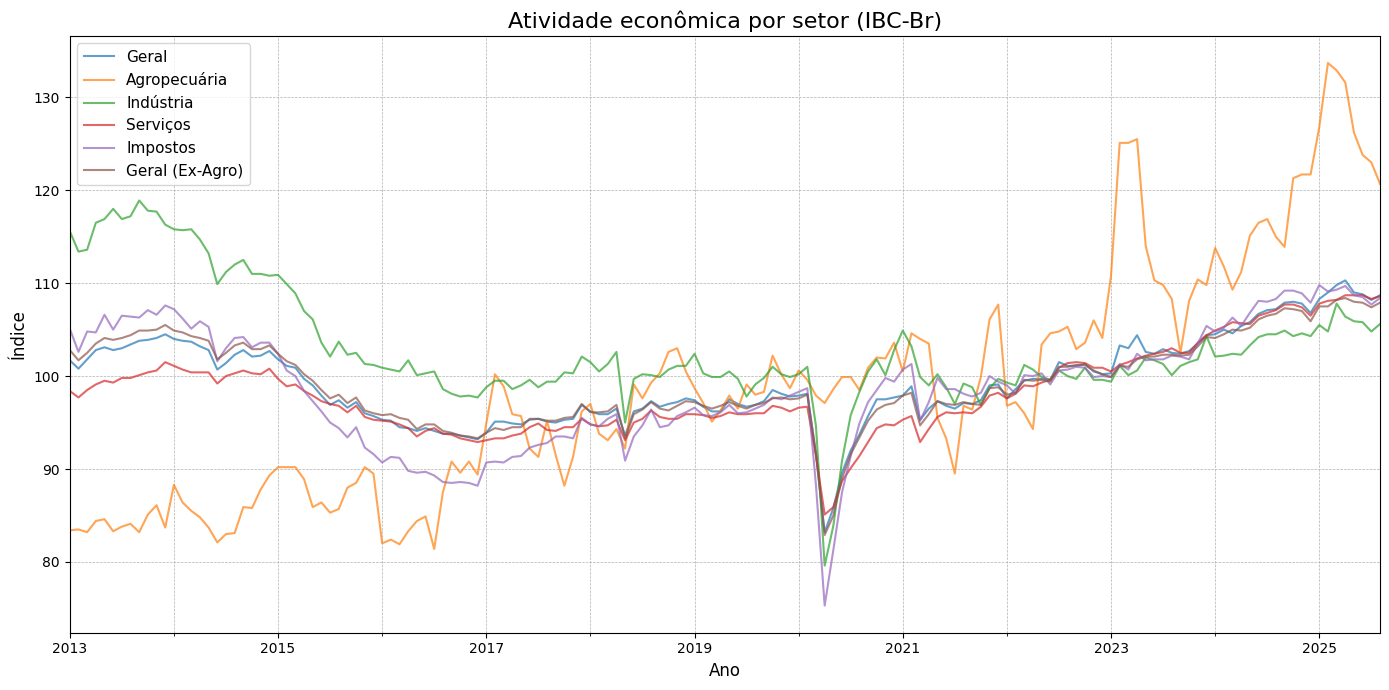

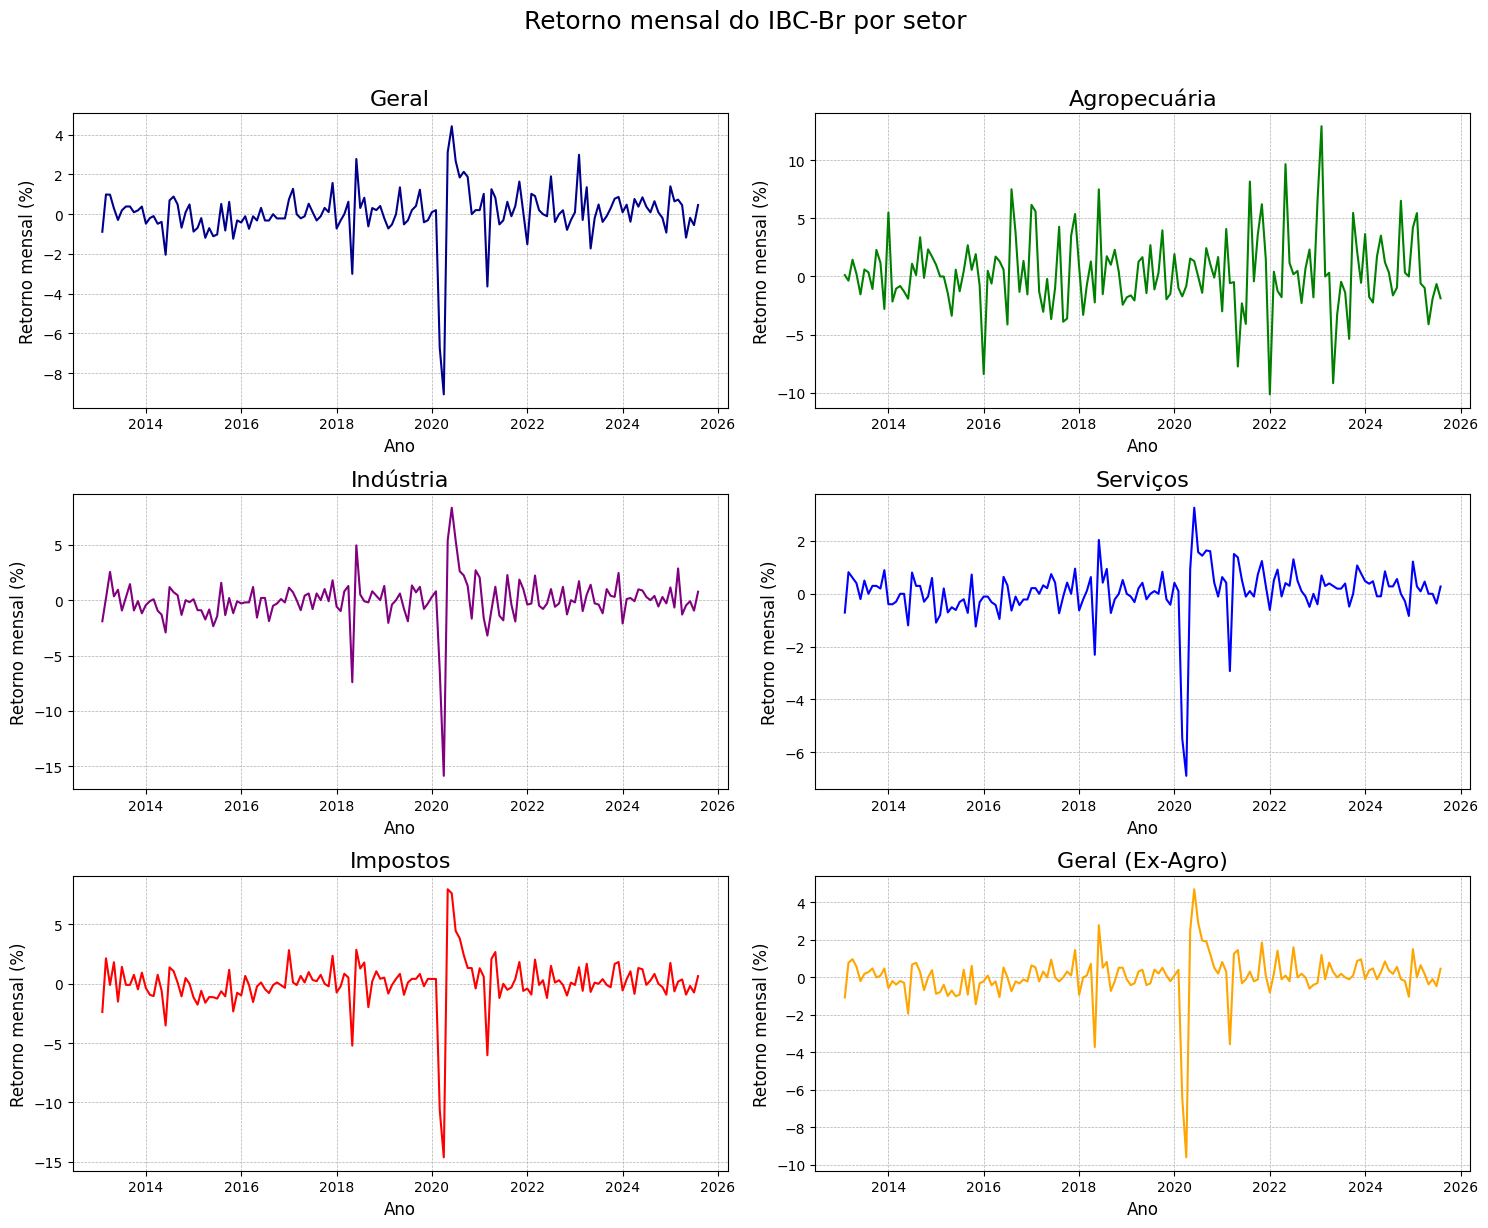

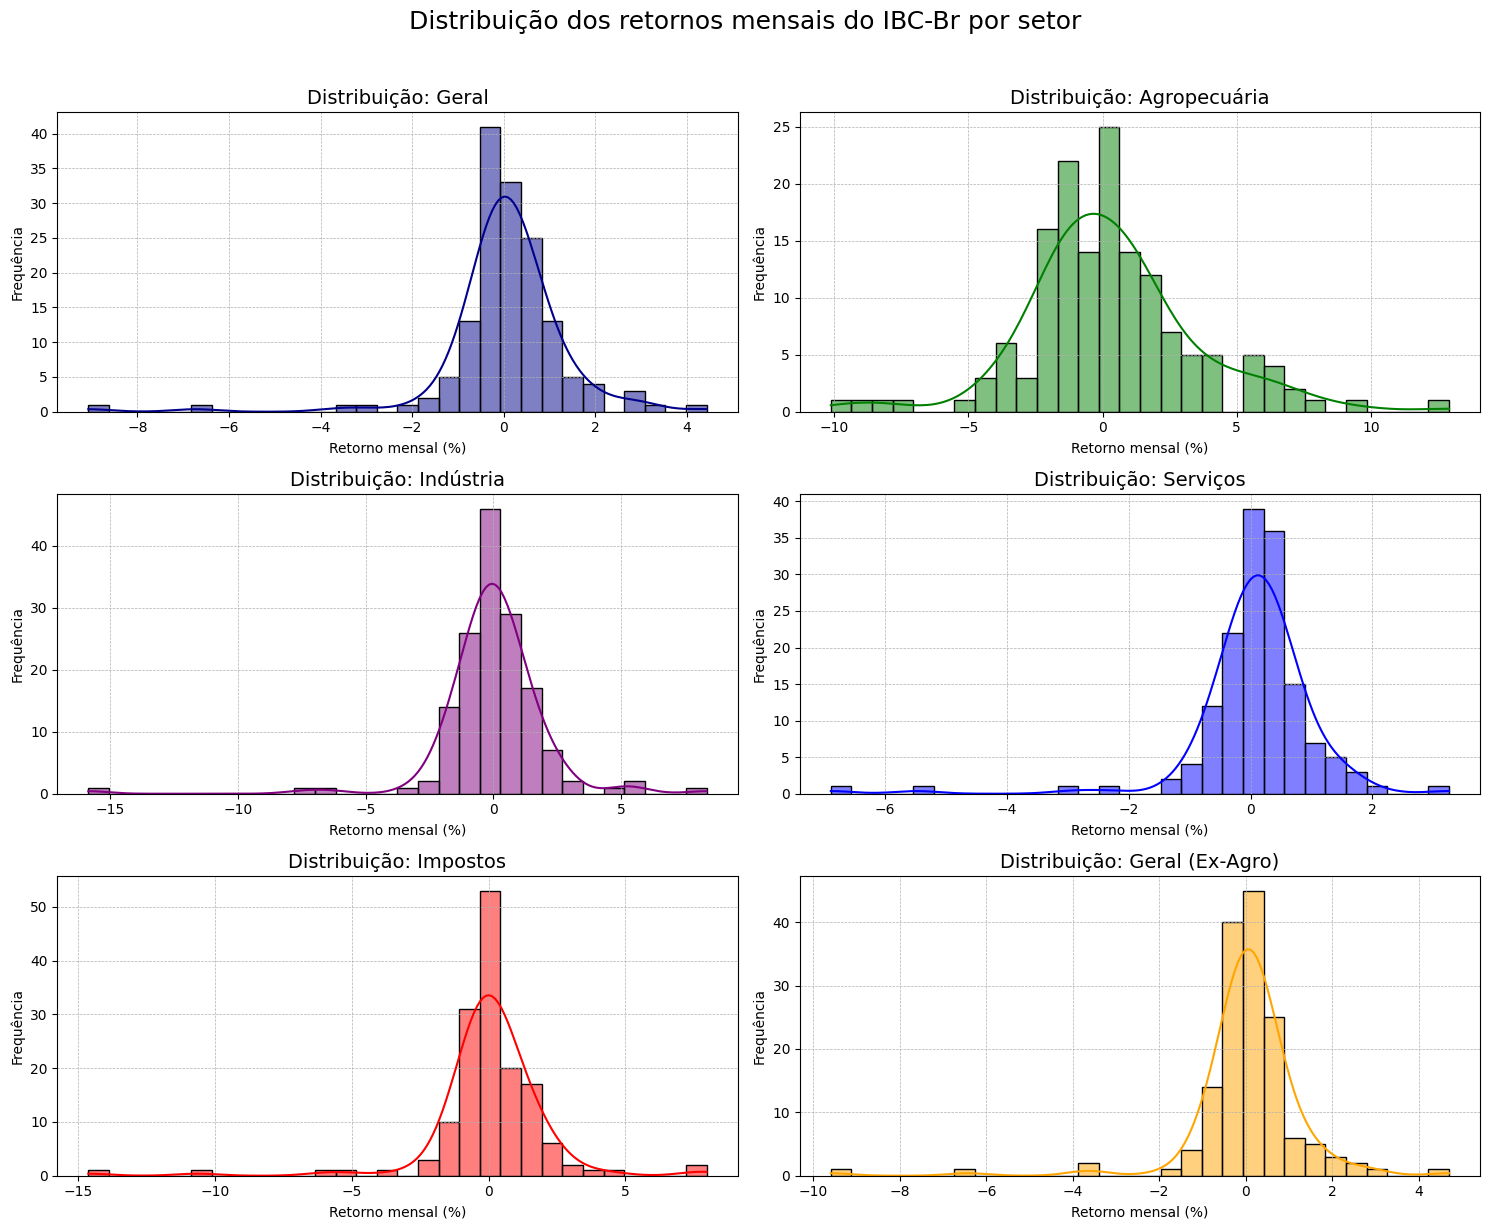

In [24]:
df_ibc = load_macro_data("data/ibc_br.csv")


plt.figure(figsize=(14, 7))
df_ibc["IBC_HEADLINE"].plot(color="darkblue", linewidth=2)
plt.title(
    "Índice de Atividade Econômica do Banco Central (IBC-Br) - Nível", fontsize=16
)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Índice (Pontos)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

series_to_plot = [
    "IBC_HEADLINE",
    "IBC_AGRO",
    "IBC_INDUSTRY",
    "IBC_SERVICES",
    "IBC_TAXES",
    "IBC_EX_AGRO",
]

titles = [
    "Geral",
    "Agropecuária",
    "Indústria",
    "Serviços",
    "Impostos",
    "Geral (Ex-Agro)",
]

colors = ["darkblue", "green", "purple", "blue", "red", "orange"]


mon_changes = df_ibc[series_to_plot].pct_change() * 100

plt.figure(figsize=(14, 7))
for series, title, color in zip(series_to_plot, titles, colors):
    df_ibc[series].plot(label=title, alpha=0.7)

    plt.title("Atividade econômica por setor (IBC-Br)", fontsize=16)
    plt.xlabel("Ano", fontsize=12)
    plt.ylabel("Índice", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes_flat = axes.flatten()
fig.suptitle("Retorno mensal do IBC-Br por setor", fontsize=18, y=1.02)
for ax, series, title, color in zip(axes_flat, series_to_plot, titles, colors):
    ax.plot(mon_changes[series], color=color)
    ax.set_title(f"{title}", fontsize=16)
    ax.set_xlabel("Ano", fontsize=12)
    ax.set_ylabel("Retorno mensal (%)", fontsize=12)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes_flat = axes.flatten()
fig.suptitle(
    "Distribuição dos retornos mensais do IBC-Br por setor", fontsize=18, y=1.02
)
for ax, series, title, color in zip(axes_flat, series_to_plot, titles, colors):
    sns.histplot(
        mon_changes[series].dropna(),
        bins=30,
        kde=True,
        color=color,
        edgecolor="black",
        ax=ax,
    )
    ax.set_title(f"Distribuição: {title}", fontsize=14)
    ax.set_xlabel("Retorno mensal (%)", fontsize=10)
    ax.set_ylabel("Frequência", fontsize=10)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()